This codebook will demonstrate working on the Prophet algorithm using the Adobe historical stock dataset. First, the necessary libraries need to be imported.

In [1]:
# import necessary libraries
import numpy as np #for powerful array and fast math operations
import pandas as pd #for creating and working on dataframes
import matplotlib.pyplot as plt #for creating plots and charts
import seaborn as sns #another visualization library for better and easier plots
import kagglehub #for interacting with kaggle to download datasets
import os #for interacting with the os to read csv
import prophet #importing the prophet library
from prophet.make_holidays import make_holidays_df #importing holidays for the algorithm

Now the dataset needs to be loaded. It will be loaded and handled with kagglehub and os libraries.

In [2]:
# Download latest version of the dataset
path = kagglehub.dataset_download("paultimothymooney/stock-market-data")

print("Path to dataset files:", path)

100%|██████████| 1.03G/1.03G [00:37<00:00, 29.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/stock-market-data/versions/74


In [3]:
# `path` points to the downloaded dataset directory
dataset_dir = path

# List files in the dataset directory to identify the data files
print("Files in dataset directory:", os.listdir(dataset_dir))

Files in dataset directory: ['stock_market_data']


Now the dataset will be read using the read.csv function and the first few columns along with data types will be observed.

In [4]:
# Load Adobe stock data
adbe_path = os.path.join(dataset_dir, "stock_market_data", "nasdaq", "csv", "ADBE.csv")
adbe_df = pd.read_csv(adbe_path)

# Inspect first rows
print(adbe_df.head())
print(adbe_df.info())

         Date       Low  Open    Volume      High     Close  Adjusted Close
0  13-08-1986  0.210938   0.0  18899200  0.218750  0.210938        0.198057
1  14-08-1986  0.222656   0.0   4160000  0.230469  0.222656        0.209060
2  15-08-1986  0.218750   0.0   4332800  0.222656  0.218750        0.205392
3  18-08-1986  0.210938   0.0   2828800  0.218750  0.210938        0.198057
4  19-08-1986  0.214844   0.0   2060800  0.218750  0.214844        0.201725
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9158 entries, 0 to 9157
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            9158 non-null   object 
 1   Low             9158 non-null   float64
 2   Open            9158 non-null   float64
 3   Volume          9158 non-null   int64  
 4   High            9158 non-null   float64
 5   Close           9158 non-null   float64
 6   Adjusted Close  9158 non-null   float64
dtypes: float64(5), int64(1), obj

The output from the last cell showed that the 'Date' column contains object datatype. But Prophet requires the the date to be datetime format. The following cell will convert the dates to datetime format.

In [5]:
# Turning dates into datetime format
adbe_df['Date'] = pd.to_datetime(adbe_df['Date'], dayfirst = True)

In [6]:
adbe_df.tail(n=20)

,Date,Low,Open,Volume,High,Close,Adjusted Close
9138,2022-11-14,334.429993,338.070007,3464500,345.109985,340.369995,340.369995
9139,2022-11-15,342.559998,348.410004,2948600,350.970001,345.959991,345.959991
9140,2022-11-16,336.720001,345.000000,2123200,345.019989,338.410004,338.410004
9141,2022-11-17,329.350006,331.739990,2740400,339.869995,337.829987,337.829987
9142,2022-11-18,329.140015,344.299988,3421700,344.700012,330.859985,330.859985
9143,2022-11-21,320.600006,329.529999,3219900,330.250000,321.489990,321.489990
9144,2022-11-22,320.200012,322.489990,2573800,331.540009,330.880005,330.880005
9145,2022-11-23,327.589996,329.929993,2240800,338.500000,335.779999,335.779999
9146,2022-11-25,332.010010,332.890015,1197800,335.510010,334.299988,334.299988
9147,2022-11-28,328.070007,335.829987,2314800,338.190002,328.970001,328.970001


Now the dataset needs to be checked for any missing dates. For this, I'll first find out the total range of date the data spans over. From this, I'll calculate the total calendar days. Then I'll subtract from it the available dates in my dataset, the holidays, and the weekends. This will give me the missing dates.

In [7]:
# Find the total number of dates available in the dataset
start_date = adbe_df['Date'].min()
end_date = adbe_df['Date'].max()

print(f"Date range: {start_date} to {end_date}")

Date range: 1986-08-13 00:00:00 to 2022-12-12 00:00:00


In [8]:
# Calculate the total number of calendar days in the timeline
full_timeline = pd.date_range(start=start_date, end=end_date, freq='D')
total_calendar_days = len(full_timeline)
# Calculate the number of days available in the dataset
available_data_days = len(adbe_df)
print(f"Total calendar days in the timeline: {total_calendar_days}")
print(f"Number of days with available data: {available_data_days}")

Total calendar days in the timeline: 13271
Number of days with available data: 9158


In [9]:
# Calculate the number of weekends in the timeline
number_of_weekends = sum(full_timeline.dayofweek >= 5)
print(f"Number of weekend days (Sat/Sun): {number_of_weekends}")

Number of weekend days (Sat/Sun): 3792


In [10]:
# Calculate the number of holidays for the period
year_list = range(start_date.year, end_date.year + 1)
holidays_df = make_holidays_df(year_list=year_list, country='US')
# Filter holidays to be within the timeline and not on a weekend
holidays_in_timeline = holidays_df[(holidays_df['ds'] >= start_date) & (holidays_df['ds'] <= end_date) & (holidays_df['ds'].dt.dayofweek < 5)]
number_of_holidays = len(holidays_in_timeline)
print(f"Number of public holiday weekdays: {number_of_holidays}")

Number of public holiday weekdays: 366


In [11]:
# find the days that are missing on the dataset
missing_days = total_calendar_days - available_data_days - number_of_weekends - number_of_holidays
print(f"Missing days in the dataset: {missing_days}")

Missing days in the dataset: -45


Here the negative number is because prophet's holiday library includes some holidays on which stock market stays open. Since the number is only 45 in the span of 36 years, this is minimal and therefore it is ignoreable.

Now I'll prepare my data for Prophet algorithm. Since 2020 contains the COVID pandemic, an anomaly that caused a lot of volatility, I'll train and test my model with data up till 2020.

In [12]:
# Filter a range for model training
start_date = '1986-08-13'
end_date = '2018-12-31'

# Filter ADBE stock
adbe_train = adbe_df[(adbe_df['Date'] >= start_date) & (adbe_df['Date'] <= end_date)].copy()

adbe_train = adbe_train.set_index('Date')

In [13]:
# inspect the dataset
adbe_train.head(n=20)

,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,
1986-08-13,0.210938,0.0,18899200,0.218750,0.210938,0.198057
1986-08-14,0.222656,0.0,4160000,0.230469,0.222656,0.209060
1986-08-15,0.218750,0.0,4332800,0.222656,0.218750,0.205392
1986-08-18,0.210938,0.0,2828800,0.218750,0.210938,0.198057
1986-08-19,0.214844,0.0,2060800,0.218750,0.214844,0.201725
1986-08-20,0.214844,0.0,684800,0.226563,0.214844,0.201725
1986-08-21,0.222656,0.0,883200,0.234375,0.222656,0.209060
1986-08-22,0.222656,0.0,1734400,0.230469,0.222656,0.209060
1986-08-25,0.214844,0.0,627200,0.222656,0.214844,0.201725


Now I'll check for any duplicates dates, because each date should only have one value for each of the columns and therefore only one row.

In [14]:
# check for duplictaes
duplicate = adbe_train.reset_index().duplicated(subset=['Date'])
adbe_train[duplicate.values]

,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,


Since there are no duplicates found, I'll go forward to check the relationship between the variables. The 'pairplot' function shows the realationship between each variable in separate graphs, making it easy to inspect the realtion and find an anomaly.

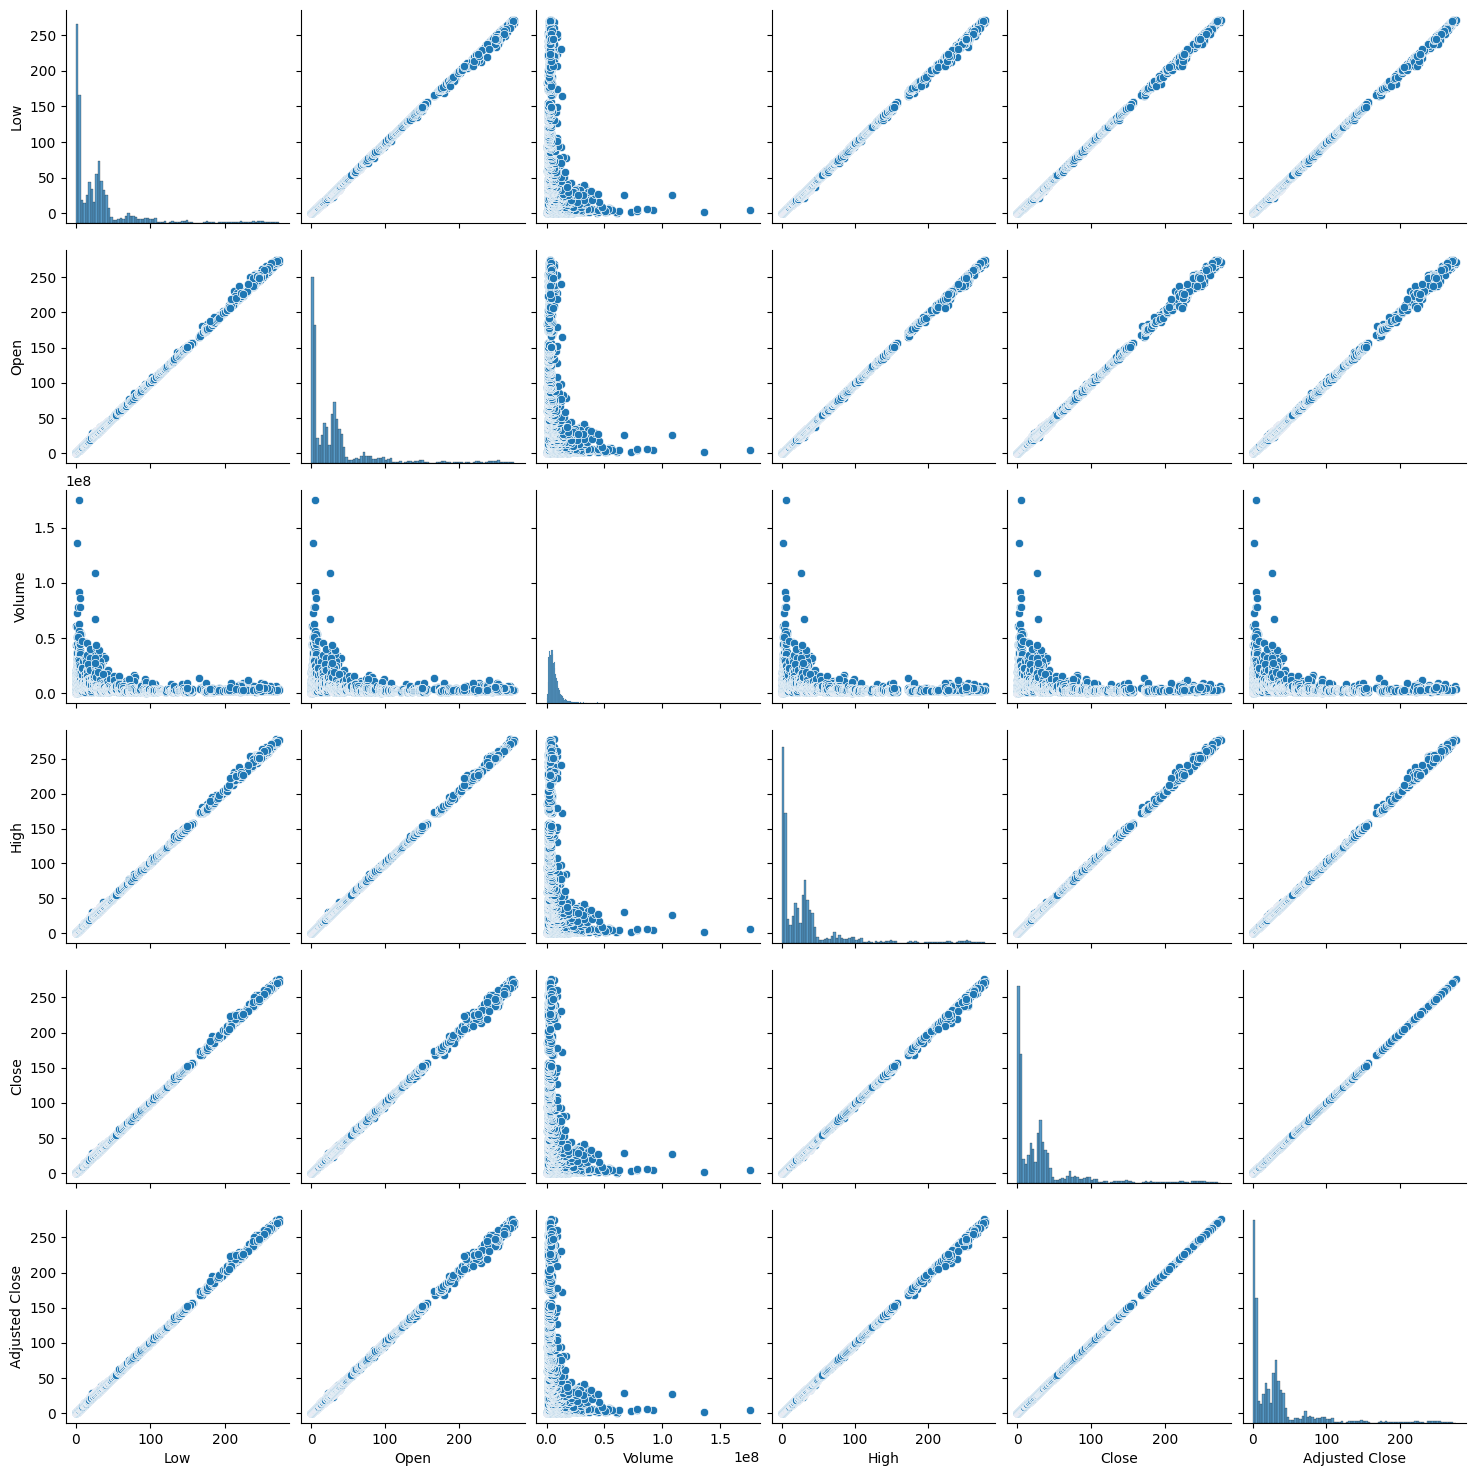

In [15]:
sns.pairplot(adbe_train)
plt.show()

Now I'll create a new dataframe with only the necessary columns. Prophet requires the 'Dates' column to be named 'ds', and the column we'll predict (here 'Adjusted Close') to be named 'y'. Tlog transform the variables, because it stabilizes the variables and handles non-linear growth, that are usually seen in stock data.

In [16]:
train_df = adbe_train[['Adjusted Close']].reset_index()
train_df.rename(columns={'Date': 'ds', 'Adjusted Close': 'y'}, inplace=True)
train_df.head(n=20)

,ds,y
0,1986-08-13,0.198057
1,1986-08-14,0.209060
2,1986-08-15,0.205392
3,1986-08-18,0.198057
4,1986-08-19,0.201725
5,1986-08-20,0.201725
6,1986-08-21,0.209060
7,1986-08-22,0.209060
8,1986-08-25,0.201725
9,1986-08-26,0.201725


In [17]:
# log transformation
import numpy as np
train_df_log = train_df.copy()
train_df_log['y'] = np.log1p(train_df_log['y'])
train_df_log.head(n=10)

,ds,y
0,1986-08-13,0.180701
1,1986-08-14,0.189843
2,1986-08-15,0.186805
3,1986-08-18,0.180701
4,1986-08-19,0.183758
5,1986-08-20,0.183758
6,1986-08-21,0.189843
7,1986-08-22,0.189843
8,1986-08-25,0.183758
9,1986-08-26,0.183758


I'll train 2 models. At first will be using the built in methods without any added regressors. Then I'll add some regressors to see if that helps the model's predictions.

I'll use the same train size, horizon, and storage for metrices for comparability. i'll train on 90% of data using a 60 day horizon for forecasting.

In [40]:
# Parameters for model traininng
initial_train_size = int(0.8 * len(train_df_log))
horizon = 60
n_iterations = (len(train_df_log) - initial_train_size) // horizon

# Storage for metrics
metrics_1 = {'mae': [], 'rmse': [], 'mape': [], 'r2': []}

Now I'll import holidays from the Prophet's built in methods. Adding holidays is importatnt because holidays introduce sudden spikes in stock proces.

In [19]:
from prophet import Prophet
from prophet.make_holidays import make_holidays_df

# Make holidays DataFrame for US
holidays = make_holidays_df(year_list=range(1986, 2022), country='US')

Now I'll train the first model. It'll be a basic model without regressors using the Prophet's built in cross validation function for this.

In [20]:
# built in cross validation model (without any added regressors)
import prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import logging

# Suppress warnings using logging
logging.getLogger('prophet').setLevel(logging.ERROR)

# Initialize and tune Prophet with built-in components
model_1 = Prophet(
    growth='linear', #assuming data grows and shrinks at steady rate without caps
    daily_seasonality=False, #since there's no hourly data
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='additive', #because the data is log-transformed
    changepoint_prior_scale=0.5, #higher value for more flexibility and trend changes
    interval_width=0.95, #95% confidence interval
    uncertainty_samples=1000, #more samples for more stable interval
    seasonality_prior_scale=0.1, #small to smooth out the seasonality to reduce overfitting
    holidays=holidays
)

# Add quarterly seasonality to reflect quaterly patterns
model_1.add_seasonality(name='quarterly', period=91.3, fourier_order=5) #stock data usually show quarterly seasonality

print(f"\nTraining Prophet on {len(train_df_log)} data points")
model_1.fit(train_df_log)

# Cross-validation with parameter tuning
print(f"\nRunning cross-validation:")
print(f"  Initial training size: {initial_train_size} days (90% of data)")
print(f"  Horizon: {horizon} days")
print(f"  Number of folds: {n_iterations}")

df_cv = cross_validation(
    model_1,
    initial=f'{initial_train_size} days',
    horizon=f'{horizon} days',
    period=f'{horizon} days',
    parallel='processes'
)

print(f"  Total predictions made: {len(df_cv)}")

# Reverse log transformation for actual scale metrics
df_cv['y_actual'] = np.expm1(df_cv['y'])
df_cv['yhat_actual'] = np.expm1(df_cv['yhat'])
df_cv['yhat_lower_actual'] = np.expm1(df_cv['yhat_lower'])
df_cv['yhat_upper_actual'] = np.expm1(df_cv['yhat_upper'])

# Store predictions dataframe
predictions_cv_no_regressors = df_cv.copy()

# Calculate metrics in original scale
mae = mean_absolute_error(df_cv['y_actual'], df_cv['yhat_actual'])
rmse = np.sqrt(mean_squared_error(df_cv['y_actual'], df_cv['yhat_actual']))
mape = np.mean(np.abs((df_cv['y_actual'] - df_cv['yhat_actual']) / (df_cv['y_actual'] + 1e-8))) * 100
r2 = r2_score(df_cv['y_actual'], df_cv['yhat_actual'])

# Coverage analysis
in_interval = np.sum((df_cv['y_actual'] >= df_cv['yhat_lower_actual']) &
                     (df_cv['y_actual'] <= df_cv['yhat_upper_actual']))
coverage_pct = (in_interval / len(df_cv)) * 100
avg_width_pct = np.mean((df_cv['yhat_upper_actual'] - df_cv['yhat_lower_actual']) /
                        df_cv['y_actual']) * 100

print("Model results with built_in components:")

print(f"\nMAE      = {mae:.3f}")
print(f"RMSE     = {rmse:.3f}")
print(f"MAPE     = {mape:.3f}")
print(f"R²       = {r2:.4f}")

print(f"\nCOVERAGE = {coverage_pct:.1f}%")
print(f"AVG WIDTH = {avg_width_pct:.1f}%")


Training Prophet on 8163 data points


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/6mdyne8m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/uo9zum3m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99645', 'data', 'file=/tmp/tmp6h0hzrmz/6mdyne8m.json', 'init=/tmp/tmp6h0hzrmz/uo9zum3m.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelwjy39s9s/prophet_model-20251025165018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:50:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:50:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Running cross-validation:
  Initial training size: 6530 days (90% of data)
  Horizon: 60 days
  Number of folds: 27


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/8x03our4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/2eqdnohf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/4hzewja2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88563', 'data', 'file=/tmp/tmp6h0hzrmz/2eqdnohf.json', 'init=/tmp/tmp6h0hzrmz/4hzewja2.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelq7bc_yko/prophet_model-20251025165036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:50:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/ra__ub28.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34120', 'data

  Total predictions made: 3640
Model results with built_in components:

MAE      = 10.290
RMSE     = 15.174
MAPE     = 18.515
R²       = 0.9289

COVERAGE = 75.3%
AVG WIDTH = 52.3%


Although this model resulted in decent r2 value and coverage, the MAE, RMSE, and MAPE values are not ideal for a stock forecasting model.

I'll use the following cell to save the predictions now, so I don't have to run it everytime my runtime disconnects to get the results.

In [21]:
# Save the predictions after running model 1
import pickle
predictions_cv_no_regressors.to_csv('predictions_cv_no_regressors.csv', index=False)
print("Saved predictions_cv_no_regressors")

Saved predictions_cv_no_regressors


In [22]:
# load the predictions to chcek
predictions_cv_no_regressors = pd.read_csv('predictions_cv_no_regressors.csv', parse_dates=['ds'])
predictions_cv_no_regressors.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,y_actual,yhat_actual,yhat_lower_actual,yhat_upper_actual
0,2004-07-19,2.865383,2.560300,3.168360,3.094712,2004-07-17,21.080879,16.555783,11.939693,22.768461
1,2004-07-20,2.862109,2.539408,3.155915,3.099228,2004-07-17,21.180811,16.498399,11.672170,22.474499
2,2004-07-21,2.856684,2.563381,3.152198,3.064620,2004-07-17,20.426317,16.403728,11.979633,22.387416
3,2004-07-22,2.852035,2.560083,3.186802,3.062986,2004-07-17,20.391338,16.322996,11.936888,23.210868
4,2004-07-23,2.844008,2.538095,3.132112,3.052183,2004-07-17,20.161493,16.184505,11.655543,21.922339


Now I'll visualize all the components (weekly, yearly, and quately seasonality,holiday, and trend) using Prophet's built in plot_components. This gives us a clear idea about the patterns.

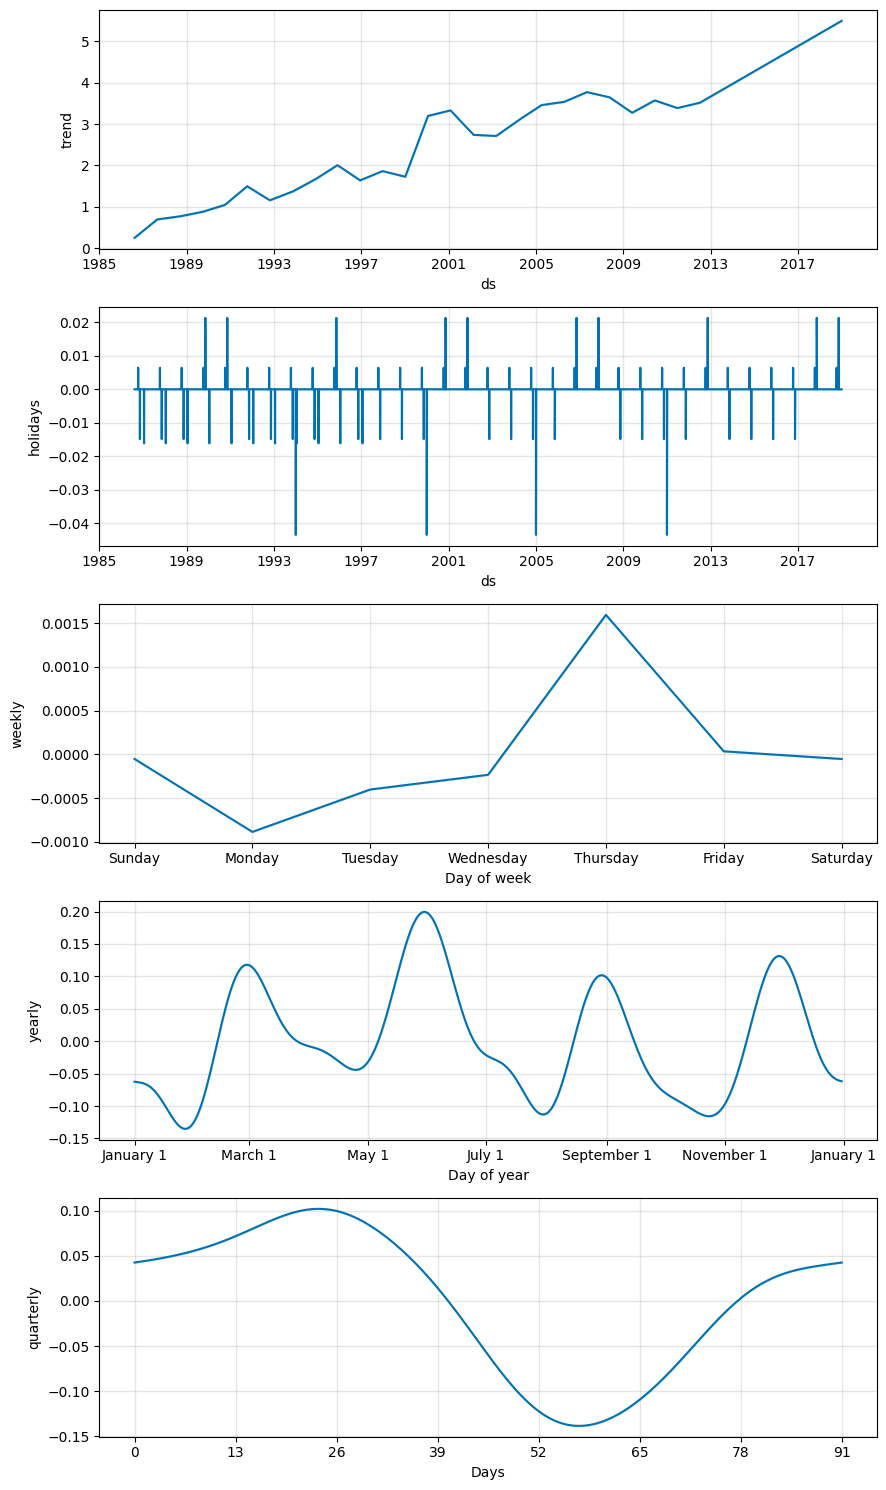

In [23]:
# Visualize all the components of the dataset
forecast_model_1 = model_1.predict(train_df_log)

figure_1 = model_1.plot_components(forecast_model_1)
plt.show()

Now I'll visualize the MAPE metric. It shows 4% instead of 16% because it's calculated in the log transformed space.

/usr/local/lib/python3.12/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


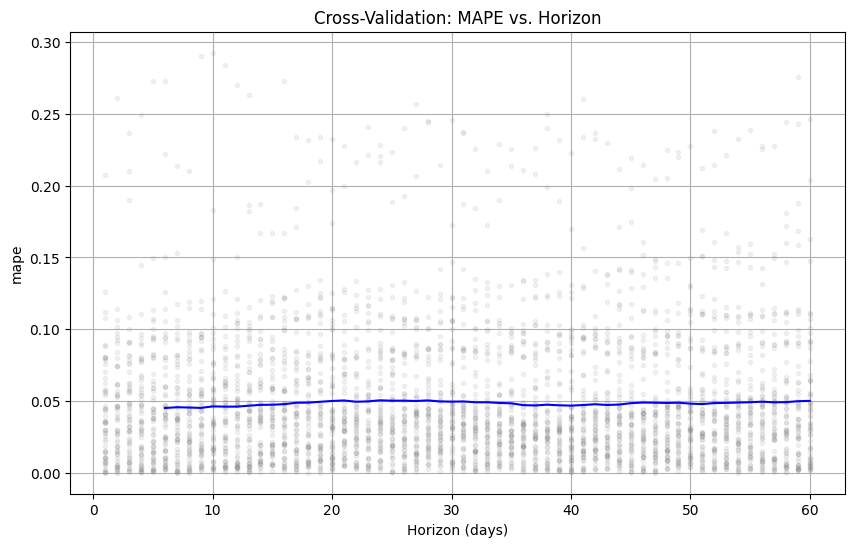

In [24]:
from prophet.plot import plot_cross_validation_metric
# You can change 'mape' to 'rmse', 'mae', or 'mdape'.
fiure_2 = plot_cross_validation_metric(df_cv, metric='mape')
plt.title("Cross-Validation: MAPE vs. Horizon")
plt.show()

Now I'll train the model creating and adding some regressors to see if they improve the model's prediction. The regressors are not exogenous in nature, and are derived from this dataset. I'll use autoregression to predict future regressors and avoid any data leakage. The train size and horizon will be the same as before.

In [25]:
# Parameters for iterative traininng
initial_train_size = int(0.8 * len(train_df_log))
horizon = 60
n_iterations = (len(train_df_log) - initial_train_size) // horizon

In [26]:
# Storage for metrics
metrics = {'mae': [], 'rmse': [], 'mape': [], 'r2': []}

The following model includes the following regressors: lag 1, 2, 3, and 7 (previous days' closing prices), simple moving average 7, and 30 (using rolling window means), 5 and 10 days' momentum, volatility 7 and 30 (using rolling window standard deviations), and trend strength (deviation from sma 30).

In [27]:
# Walk forward validation and performance metrics with autoregression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Main Walk-Forward Loop
train_end = initial_train_size
all_fold_forecasts = []
coverage_metrics = {'in_coverage': [], 'coverage_width': []}

# Store all predictions for later visualization
all_predictions_list = []

for i in range(n_iterations):
    # Define current training and testing windows
    current_train = train_df_log.iloc[:train_end].copy()
    test_start = train_end
    test_end = min(train_end + horizon, len(train_df_log))
    test_df = train_df_log.iloc[test_start:test_end].copy()

    if len(test_df) == 0:
        break

    print(f"Iteration {i+1}/{n_iterations}: Training on {len(current_train)} data points, testing on {len(test_df)}.")

    # Recalculate features on the loop to avoid leakage
    current_train_clean = current_train[['ds', 'y']].copy()

    # Include basic lags
    current_train_clean['lag1'] = current_train_clean['y'].shift(1)
    current_train_clean['lag2'] = current_train_clean['y'].shift(2)
    current_train_clean['lag3'] = current_train_clean['y'].shift(3)
    current_train_clean['lag7'] = current_train_clean['y'].shift(7)

    # Include moving averages
    current_train_clean['sma_7'] = current_train_clean['y'].rolling(window=7, min_periods=1).mean()
    current_train_clean['sma_30'] = current_train_clean['y'].rolling(window=30, min_periods=1).mean()

    # Include momentum indicators
    current_train_clean['momentum_5'] = current_train_clean['y'] - current_train_clean['y'].shift(5)
    current_train_clean['momentum_10'] = current_train_clean['y'] - current_train_clean['y'].shift(10)

    # Include volatility (rolling std)
    current_train_clean['volatility_7'] = current_train_clean['y'].rolling(window=7, min_periods=1).std()
    current_train_clean['volatility_30'] = current_train_clean['y'].rolling(window=30, min_periods=1).std()

    # Include trend strength (price relative to moving average)
    current_train_clean['trend_strength'] = current_train_clean['y'] - current_train_clean['sma_30']

    # Drop rows with NaN
    current_train_clean = current_train_clean.dropna()

    if len(current_train_clean) < 50:
        print("  Insufficient training data after feature engineering. Skipping.")
        continue

    # Initialize and Fit Model with Reduced Seasonality
    model_2 = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='additive',
        changepoint_prior_scale=0.05,  # Lower value is less flexible (prevents overfitting)
        interval_width=0.95,
        uncertainty_samples=1000,
        seasonality_prior_scale=0.1,
        holidays=holidays
    )

    # Add regressors to the model
    regressors = ['lag1', 'lag2', 'lag3', 'lag7', 'sma_7', 'sma_30', 'momentum_5', 'momentum_10', 'volatility_7', 'volatility_30', 'trend_strength']

    for reg in regressors:
        model_2.add_regressor(reg)
    model_2.add_seasonality(name='quarterly', period=91.3, fourier_order=5)

    model_2.fit(current_train_clean)

    # Forecasting with Actual Values (not recursive)
    history_y = current_train_clean['y'].values.tolist()
    fold_predictions = []
    actual_dates = test_df['ds'].values

    for step in range(len(test_df)):
        # Create future dataframe
        future_step_df = pd.DataFrame({'ds': [actual_dates[step]]})

        # Calculate regressors from history
        history_array = np.array(history_y)

        future_step_df['lag1'] = history_array[-1]
        future_step_df['lag2'] = history_array[-2]
        future_step_df['lag3'] = history_array[-3]
        future_step_df['lag7'] = history_array[-7] if len(history_array) >= 7 else history_array[0]

        future_step_df['sma_7'] = history_array[-7:].mean() if len(history_array) >= 7 else history_array.mean()
        future_step_df['sma_30'] = history_array[-30:].mean() if len(history_array) >= 30 else history_array.mean()

        future_step_df['momentum_5'] = history_array[-1] - (history_array[-6] if len(history_array) >= 6 else history_array[0])
        future_step_df['momentum_10'] = history_array[-1] - (history_array[-11] if len(history_array) >= 11 else history_array[0])

        future_step_df['volatility_7'] = np.std(history_array[-7:]) if len(history_array) >= 7 else 0
        future_step_df['volatility_30'] = np.std(history_array[-30:]) if len(history_array) >= 30 else 0

        sma_30_current = history_array[-30:].mean() if len(history_array) >= 30 else history_array.mean()
        future_step_df['trend_strength'] = history_array[-1] - sma_30_current

        # Make prediction with intervals
        forecast_step = model_2.predict(future_step_df)
        fold_predictions.append(forecast_step)

        # Use actual value for next iteration
        actual_log_value = test_df.iloc[step]['y']
        history_y.append(actual_log_value)

    # Calculate Metrics with Coverage
    fold_forecast_df = pd.concat(fold_predictions).reset_index(drop=True)
    all_fold_forecasts.append(fold_forecast_df)

    # Reverse log transformation
    y_true_original_2 = np.expm1(test_df['y'].values)
    y_pred_original_2 = np.expm1(fold_forecast_df['yhat'].values)
    y_lower_original_2 = np.expm1(fold_forecast_df['yhat_lower'].values)
    y_upper_original_2 = np.expm1(fold_forecast_df['yhat_upper'].values)

    # Store predictions for this fold
    for j in range(len(test_df)):
        all_predictions_list.append({
            'ds': test_df.iloc[j]['ds'],
            'y_actual_log': test_df.iloc[j]['y'],
            'y_actual': y_true_original_2[j],
            'y_pred_log': fold_forecast_df.iloc[j]['yhat'],
            'y_pred': y_pred_original_2[j],
            'y_lower_log': fold_forecast_df.iloc[j]['yhat_lower'],
            'y_lower': y_lower_original_2[j],
            'y_upper_log': fold_forecast_df.iloc[j]['yhat_upper'],
            'y_upper': y_upper_original_2[j],
            'fold': i + 1
        })

    # Standard metrics
    mae = mean_absolute_error(y_true_original_2, y_pred_original_2)
    rmse = np.sqrt(mean_squared_error(y_true_original_2, y_pred_original_2))
    mape = np.mean(np.abs((y_true_original_2 - y_pred_original_2) / (y_true_original_2 + 1e-8))) * 100
    r2 = r2_score(y_true_original_2, y_pred_original_2)

    # Coverage metrics
    in_interval = np.sum((y_true_original_2 >= y_lower_original_2) & (y_true_original_2 <= y_upper_original_2))
    coverage = (in_interval / len(y_true_original_2)) * 100
    avg_interval_width = np.mean(y_upper_original_2 - y_lower_original_2)
    avg_interval_width_pct = np.mean((y_upper_original_2 - y_lower_original_2) / y_true_original_2) * 100


    metrics['mae'].append(mae)
    metrics['rmse'].append(rmse)
    metrics['mape'].append(mape)
    metrics['r2'].append(r2)
    coverage_metrics['in_coverage'].append(coverage)
    coverage_metrics['coverage_width'].append(avg_interval_width_pct)

    # Move the training window (candlestick method)
    train_end += horizon

    print(f"    MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}% | R²: {r2:.3f}")
    print(f"    Coverage: {coverage:.1f}% | Avg Width: {avg_interval_width_pct:.1f}%")

# Create comprehensive predictions dataframe
predictions_df_with_regressors_nr = pd.DataFrame(all_predictions_list)

# Aggregate and Display Final Metrics
print("AGGREGATED METRICS (Walk-Forward Validation with added regressors)")

agg_metrics = {k: np.mean(v) for k, v in metrics.items()}
for k, v in agg_metrics.items():
    std_val = np.std(metrics[k])
    print(f"{k.upper():8} = {v:7.3f} (±{std_val:.3f})")

print(f"\nCOVERAGE  = {np.mean(coverage_metrics['in_coverage']):7.1f}% (±{np.std(coverage_metrics['in_coverage']):.1f}%)")
print(f"AVG WIDTH = {np.mean(coverage_metrics['coverage_width']):7.1f}% (±{np.std(coverage_metrics['coverage_width']):.1f}%)")


Iteration 1/27: Training on 6530 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/7iv4qtfx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/m4lael1g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28064', 'data', 'file=/tmp/tmp6h0hzrmz/7iv4qtfx.json', 'init=/tmp/tmp6h0hzrmz/m4lael1g.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelrotfq0j2/prophet_model-20251025170418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:04:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 0.43 | RMSE: 0.55 | MAPE: 1.33% | R²: 0.761
    Coverage: 11.7% | Avg Width: 0.5%
Iteration 2/27: Training on 6590 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/efl6gjc5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/xyh5tibh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86134', 'data', 'file=/tmp/tmp6h0hzrmz/efl6gjc5.json', 'init=/tmp/tmp6h0hzrmz/xyh5tibh.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelvz07lpuo/prophet_model-20251025170449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:04:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/oow8231z.json


    MAE: 0.29 | RMSE: 0.42 | MAPE: 0.85% | R²: 0.943
    Coverage: 16.7% | Avg Width: 0.4%
Iteration 3/27: Training on 6650 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/2jurqj5_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54724', 'data', 'file=/tmp/tmp6h0hzrmz/oow8231z.json', 'init=/tmp/tmp6h0hzrmz/2jurqj5_.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelbav6ev0s/prophet_model-20251025170521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:05:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/yqjh90g7.json


    MAE: 0.35 | RMSE: 0.47 | MAPE: 0.89% | R²: 0.910
    Coverage: 18.3% | Avg Width: 0.5%
Iteration 4/27: Training on 6710 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/p4zult44.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20709', 'data', 'file=/tmp/tmp6h0hzrmz/yqjh90g7.json', 'init=/tmp/tmp6h0hzrmz/p4zult44.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelflm5ha_u/prophet_model-20251025170554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:05:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/b80oubaq.json


    MAE: 0.49 | RMSE: 0.62 | MAPE: 1.10% | R²: 0.603
    Coverage: 8.3% | Avg Width: 0.3%
Iteration 5/27: Training on 6770 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/7tlrayaw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51052', 'data', 'file=/tmp/tmp6h0hzrmz/b80oubaq.json', 'init=/tmp/tmp6h0hzrmz/7tlrayaw.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelunhzregf/prophet_model-20251025170628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:06:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:06:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/wdyrfs1y.json


    MAE: 0.38 | RMSE: 0.48 | MAPE: 0.81% | R²: 0.823
    Coverage: 11.7% | Avg Width: 0.4%
Iteration 6/27: Training on 6830 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/f7w28fn9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6233', 'data', 'file=/tmp/tmp6h0hzrmz/wdyrfs1y.json', 'init=/tmp/tmp6h0hzrmz/f7w28fn9.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelz_p_6prb/prophet_model-20251025170703.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:07:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/b4gv0kso.json


    MAE: 0.59 | RMSE: 0.89 | MAPE: 1.11% | R²: 0.858
    Coverage: 16.7% | Avg Width: 0.4%
Iteration 7/27: Training on 6890 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/501e98w4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53692', 'data', 'file=/tmp/tmp6h0hzrmz/b4gv0kso.json', 'init=/tmp/tmp6h0hzrmz/501e98w4.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelkccjiyo5/prophet_model-20251025170737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:07:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 0.85 | RMSE: 1.29 | MAPE: 1.38% | R²: 0.910
    Coverage: 15.0% | Avg Width: 0.5%
Iteration 8/27: Training on 6950 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/xo7lgtli.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/j0g02e3i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40272', 'data', 'file=/tmp/tmp6h0hzrmz/xo7lgtli.json', 'init=/tmp/tmp6h0hzrmz/j0g02e3i.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model3z8vpt4o/prophet_model-20251025170811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:08:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/mcqu0x0f.json


    MAE: 0.85 | RMSE: 1.01 | MAPE: 1.34% | R²: 0.851
    Coverage: 8.3% | Avg Width: 0.4%
Iteration 9/27: Training on 7010 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/tvxd1aav.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67758', 'data', 'file=/tmp/tmp6h0hzrmz/mcqu0x0f.json', 'init=/tmp/tmp6h0hzrmz/tvxd1aav.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelwa9dtblu/prophet_model-20251025170843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:08:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/fvb0hy12.json


    MAE: 0.62 | RMSE: 1.00 | MAPE: 0.87% | R²: 0.810
    Coverage: 18.3% | Avg Width: 0.5%
Iteration 10/27: Training on 7070 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/c19xdoiu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96881', 'data', 'file=/tmp/tmp6h0hzrmz/fvb0hy12.json', 'init=/tmp/tmp6h0hzrmz/c19xdoiu.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelw5m9laqr/prophet_model-20251025170917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:09:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/vtsbgozz.json


    MAE: 0.84 | RMSE: 1.09 | MAPE: 1.25% | R²: 0.872
    Coverage: 13.3% | Avg Width: 0.4%
Iteration 11/27: Training on 7130 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/7vxm0sor.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1949', 'data', 'file=/tmp/tmp6h0hzrmz/vtsbgozz.json', 'init=/tmp/tmp6h0hzrmz/7vxm0sor.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelhy7pcrew/prophet_model-20251025170951.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:09:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/qm1webvp.json


    MAE: 0.85 | RMSE: 1.26 | MAPE: 1.16% | R²: 0.538
    Coverage: 16.7% | Avg Width: 0.6%
Iteration 12/27: Training on 7190 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/kgxdl7zp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97131', 'data', 'file=/tmp/tmp6h0hzrmz/qm1webvp.json', 'init=/tmp/tmp6h0hzrmz/kgxdl7zp.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelu064b55p/prophet_model-20251025171025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:10:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:10:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/pv_trmdg.json


    MAE: 0.73 | RMSE: 0.94 | MAPE: 0.95% | R²: 0.691
    Coverage: 11.7% | Avg Width: 0.4%
Iteration 13/27: Training on 7250 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/9q6zk0fi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4807', 'data', 'file=/tmp/tmp6h0hzrmz/pv_trmdg.json', 'init=/tmp/tmp6h0hzrmz/9q6zk0fi.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model6qk8xngn/prophet_model-20251025171103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:11:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/tetk8amx.json


    MAE: 0.65 | RMSE: 0.83 | MAPE: 0.80% | R²: 0.685
    Coverage: 13.3% | Avg Width: 0.3%
Iteration 14/27: Training on 7310 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/ruv59us1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57249', 'data', 'file=/tmp/tmp6h0hzrmz/tetk8amx.json', 'init=/tmp/tmp6h0hzrmz/ruv59us1.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelwzjlr_va/prophet_model-20251025171140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:11:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/kymzvn85.json


    MAE: 1.29 | RMSE: 1.66 | MAPE: 1.57% | R²: 0.844
    Coverage: 6.7% | Avg Width: 0.5%
Iteration 15/27: Training on 7370 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/bvsoci64.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34800', 'data', 'file=/tmp/tmp6h0hzrmz/kymzvn85.json', 'init=/tmp/tmp6h0hzrmz/bvsoci64.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelvyr8ti4c/prophet_model-20251025171218.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:12:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 1.14 | RMSE: 1.48 | MAPE: 1.26% | R²: 0.624
    Coverage: 15.0% | Avg Width: 0.5%
Iteration 16/27: Training on 7430 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/fsjfwphm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/1nc_cjrx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68095', 'data', 'file=/tmp/tmp6h0hzrmz/fsjfwphm.json', 'init=/tmp/tmp6h0hzrmz/1nc_cjrx.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelyfshcxc1/prophet_model-20251025171257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:12:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:13:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/rxx_3lq8.json


    MAE: 1.18 | RMSE: 1.70 | MAPE: 1.38% | R²: 0.929
    Coverage: 18.3% | Avg Width: 0.4%
Iteration 17/27: Training on 7490 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/xuw215g7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22320', 'data', 'file=/tmp/tmp6h0hzrmz/rxx_3lq8.json', 'init=/tmp/tmp6h0hzrmz/xuw215g7.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelma6b5__e/prophet_model-20251025171336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:13:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:14:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/43v_7be7.json


    MAE: 0.94 | RMSE: 1.39 | MAPE: 0.98% | R²: 0.561
    Coverage: 26.7% | Avg Width: 0.6%
Iteration 18/27: Training on 7550 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/rgrh2bqo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10507', 'data', 'file=/tmp/tmp6h0hzrmz/43v_7be7.json', 'init=/tmp/tmp6h0hzrmz/rgrh2bqo.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelrj8bcnon/prophet_model-20251025171416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:14:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/r3dfa5yp.json


    MAE: 0.77 | RMSE: 1.28 | MAPE: 0.74% | R²: 0.905
    Coverage: 26.7% | Avg Width: 0.5%
Iteration 19/27: Training on 7610 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/r3ej2wvv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2771', 'data', 'file=/tmp/tmp6h0hzrmz/r3dfa5yp.json', 'init=/tmp/tmp6h0hzrmz/r3ej2wvv.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelis7i55ch/prophet_model-20251025171456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:14:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/enen7053.json


    MAE: 0.93 | RMSE: 1.22 | MAPE: 0.88% | R²: 0.737
    Coverage: 20.0% | Avg Width: 0.5%
Iteration 20/27: Training on 7670 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/w6jckfic.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80366', 'data', 'file=/tmp/tmp6h0hzrmz/enen7053.json', 'init=/tmp/tmp6h0hzrmz/w6jckfic.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model_f55lnrf/prophet_model-20251025171537.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/p6ff24da.json


    MAE: 0.68 | RMSE: 1.00 | MAPE: 0.57% | R²: 0.975
    Coverage: 30.0% | Avg Width: 0.5%
Iteration 21/27: Training on 7730 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/qah7wd1y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59316', 'data', 'file=/tmp/tmp6h0hzrmz/p6ff24da.json', 'init=/tmp/tmp6h0hzrmz/qah7wd1y.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model2nio0ylf/prophet_model-20251025171621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:16:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:16:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/n2j0qbsr.json


    MAE: 1.07 | RMSE: 1.46 | MAPE: 0.77% | R²: 0.892
    Coverage: 28.3% | Avg Width: 0.6%
Iteration 22/27: Training on 7790 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/l72x_7mj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14461', 'data', 'file=/tmp/tmp6h0hzrmz/n2j0qbsr.json', 'init=/tmp/tmp6h0hzrmz/l72x_7mj.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model8ocbr2ub/prophet_model-20251025171700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:17:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/g29u9ie6.json


    MAE: 1.22 | RMSE: 1.69 | MAPE: 0.82% | R²: 0.784
    Coverage: 25.0% | Avg Width: 0.6%
Iteration 23/27: Training on 7850 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/a5l8thad.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44978', 'data', 'file=/tmp/tmp6h0hzrmz/g29u9ie6.json', 'init=/tmp/tmp6h0hzrmz/a5l8thad.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model2tsedzxy/prophet_model-20251025171744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:17:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/zyvqu5g0.json


    MAE: 2.07 | RMSE: 3.61 | MAPE: 1.20% | R²: 0.897
    Coverage: 13.3% | Avg Width: 0.4%
Iteration 24/27: Training on 7910 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/zuluza8v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75736', 'data', 'file=/tmp/tmp6h0hzrmz/zyvqu5g0.json', 'init=/tmp/tmp6h0hzrmz/zuluza8v.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model0pv93zoy/prophet_model-20251025171826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/8tuab1kd.json


    MAE: 2.88 | RMSE: 3.80 | MAPE: 1.41% | R²: 0.924
    Coverage: 21.7% | Avg Width: 0.5%
Iteration 25/27: Training on 7970 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/vi9lyzoo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7607', 'data', 'file=/tmp/tmp6h0hzrmz/8tuab1kd.json', 'init=/tmp/tmp6h0hzrmz/vi9lyzoo.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model9kpjjse5/prophet_model-20251025171908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:19:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/0havxlsg.json


    MAE: 2.85 | RMSE: 3.83 | MAPE: 1.23% | R²: 0.917
    Coverage: 16.7% | Avg Width: 0.5%
Iteration 26/27: Training on 8030 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/0k8wjstg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58866', 'data', 'file=/tmp/tmp6h0hzrmz/0havxlsg.json', 'init=/tmp/tmp6h0hzrmz/0k8wjstg.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model2_xof231/prophet_model-20251025171954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:19:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:20:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 2.90 | RMSE: 3.76 | MAPE: 1.14% | R²: 0.800
    Coverage: 11.7% | Avg Width: 0.5%
Iteration 27/27: Training on 8090 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/e59ytzmh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/q9zxs4w_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13877', 'data', 'file=/tmp/tmp6h0hzrmz/e59ytzmh.json', 'init=/tmp/tmp6h0hzrmz/q9zxs4w_.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelrskyhfqk/prophet_model-20251025172040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:20:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:21:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 5.48 | RMSE: 7.52 | MAPE: 2.22% | R²: 0.692
    Coverage: 16.7% | Avg Width: 0.5%
AGGREGATED METRICS (Walk-Forward Validation with added regressors)
MAE      =   1.233 (±1.108)
RMSE     =   1.713 (±1.523)
MAPE     =   1.112 (±0.329)
R2       =   0.805 (±0.122)

COVERAGE  =    16.9% (±6.1%)
AVG WIDTH =     0.5% (±0.1%)


Although this model produces decent results, this is not truly recursive in nature. Rather after each predction, it uses the original values of regressors, assuming each day the values up to the previous day will be fed to the model.

Now similar to the model before, I'll store and check the predictions of this model.

In [28]:
# Saving after running model with regressors
import pickle
predictions_df_with_regressors_nr.to_csv('predictions_with_regressors_nr.csv', index=False)
with open('metrics_with_reg.pkl', 'wb') as f:
    pickle.dump(metrics, f)
print("Saved predictions_df_with_regressors_nr")

Saved predictions_df_with_regressors_nr


In [29]:
predictions_df_with_regressors_nr = pd.read_csv('predictions_with_regressors_nr.csv', parse_dates=['ds'])
predictions_df_with_regressors_nr.head()

,ds,y_actual_log,y_actual,y_pred_log,y_pred,y_lower_log,y_lower,y_upper_log,y_upper,fold
0,2012-07-05,3.512441,32.529999,3.511901,32.511901,3.509434,32.429330,3.514158,32.587647,1
1,2012-07-06,3.477232,31.370001,3.512506,32.532181,3.510097,32.451499,3.514791,32.608901,1
2,2012-07-09,3.447763,30.430000,3.477310,31.372526,3.475042,31.299171,3.479657,31.448584,1
3,2012-07-10,3.448081,30.440001,3.447858,30.432988,3.445632,30.363104,3.450520,30.516786,1
4,2012-07-11,3.440418,30.200001,3.448239,30.444974,3.445867,30.370460,3.450668,30.521443,1


Now I'll train a true recursive model. Since the errors can compound on such models, I'll use a shorter horizon of 14 days and a higher changepoint prior scale (0.5).

In [43]:
# Parameters for iterative traininng
initial_train_size = int(0.8 * len(train_df_log))
horizon = 14
n_iterations = (len(train_df_log) - initial_train_size) // horizon
# Storage for metrics
metrics = {'mae': [], 'rmse': [], 'mape': [], 'r2': []}

In [54]:
# Walk forward validation and performance metrics with autoregression (True Recursive)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Main Walk-Forward Loop
train_end = initial_train_size
all_fold_forecasts = []
coverage_metrics = {'in_coverage': [], 'coverage_width': []}

# Store all predictions for later visualization
all_predictions_list = []

for i in range(n_iterations):
    # Define current training and testing windows
    current_train = train_df_log.iloc[:train_end].copy()
    test_start = train_end
    test_end = min(train_end + horizon, len(train_df_log))
    test_df = train_df_log.iloc[test_start:test_end].copy()

    if len(test_df) == 0:
        break

    print(f"Iteration {i+1}/{n_iterations}: Training on {len(current_train)} data points, testing on {len(test_df)}.")

    # Recalculate features on the loop to avoid leakage
    current_train_clean = current_train[['ds', 'y']].copy()

    # Include basic lags
    current_train_clean['lag1'] = current_train_clean['y'].shift(1)
    current_train_clean['lag2'] = current_train_clean['y'].shift(2)
    current_train_clean['lag3'] = current_train_clean['y'].shift(3)
    current_train_clean['lag7'] = current_train_clean['y'].shift(7)

    # Include moving averages
    current_train_clean['sma_7'] = current_train_clean['y'].rolling(window=7, min_periods=1).mean()
    current_train_clean['sma_30'] = current_train_clean['y'].rolling(window=30, min_periods=1).mean()

    # Include momentum indicators
    current_train_clean['momentum_5'] = current_train_clean['y'] - current_train_clean['y'].shift(5)
    current_train_clean['momentum_10'] = current_train_clean['y'] - current_train_clean['y'].shift(10)

    # Include volatility (rolling std)
    current_train_clean['volatility_7'] = current_train_clean['y'].rolling(window=7, min_periods=1).std()
    current_train_clean['volatility_30'] = current_train_clean['y'].rolling(window=30, min_periods=1).std()

    # Include trend strength (price relative to moving average)
    current_train_clean['trend_strength'] = current_train_clean['y'] - current_train_clean['sma_30']

    # Drop rows with NaN
    current_train_clean = current_train_clean.dropna()

    if len(current_train_clean) < 50:
        print("  Insufficient training data after feature engineering. Skipping.")
        continue

    # Initialize and Fit Model with Reduced Seasonality
    model_3 = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='additive',
        changepoint_prior_scale=0.5,  # Lower value is less flexible (prevents overfitting)
        interval_width=0.95,
        uncertainty_samples=1000,
        seasonality_prior_scale=0.1,
        holidays=holidays
    )

    # Add regressors to the model
    regressors = ['lag1', 'lag2', 'lag3', 'lag7', 'sma_7', 'sma_30', 'momentum_5', 'momentum_10', 'volatility_7', 'volatility_30', 'trend_strength']

    for reg in regressors:
        model_3.add_regressor(reg)
    model_3.add_seasonality(name='quarterly', period=91.3, fourier_order=5)

    model_3.fit(current_train_clean)

    # TRUE RECURSIVE Forecasting (using predicted values)
    history_y = current_train_clean['y'].values.tolist()
    fold_predictions = []
    actual_dates = test_df['ds'].values

    for step in range(len(test_df)):
        # Create future dataframe
        future_step_df = pd.DataFrame({'ds': [actual_dates[step]]})

        # Calculate regressors from history
        history_array = np.array(history_y)

        future_step_df['lag1'] = history_array[-1]
        future_step_df['lag2'] = history_array[-2]
        future_step_df['lag3'] = history_array[-3]
        future_step_df['lag7'] = history_array[-7] if len(history_array) >= 7 else history_array[0]

        future_step_df['sma_7'] = history_array[-7:].mean() if len(history_array) >= 7 else history_array.mean()
        future_step_df['sma_30'] = history_array[-30:].mean() if len(history_array) >= 30 else history_array.mean()

        future_step_df['momentum_5'] = history_array[-1] - (history_array[-6] if len(history_array) >= 6 else history_array[0])
        future_step_df['momentum_10'] = history_array[-1] - (history_array[-11] if len(history_array) >= 11 else history_array[0])

        future_step_df['volatility_7'] = np.std(history_array[-7:]) if len(history_array) >= 7 else 0
        future_step_df['volatility_30'] = np.std(history_array[-30:]) if len(history_array) >= 30 else 0

        sma_30_current = history_array[-30:].mean() if len(history_array) >= 30 else history_array.mean()
        future_step_df['trend_strength'] = history_array[-1] - sma_30_current

        # Make prediction with intervals
        forecast_step = model_2.predict(future_step_df)
        fold_predictions.append(forecast_step)

        # TRUE RECURSIVE: Use PREDICTED value for next iteration
        predicted_log_value = forecast_step['yhat'].values[0]
        history_y.append(predicted_log_value)

    # Calculate Metrics with Coverage
    fold_forecast_df = pd.concat(fold_predictions).reset_index(drop=True)
    all_fold_forecasts.append(fold_forecast_df)

    # Reverse log transformation
    y_true_original_2 = np.expm1(test_df['y'].values)
    y_pred_original_2 = np.expm1(fold_forecast_df['yhat'].values)
    y_lower_original_2 = np.expm1(fold_forecast_df['yhat_lower'].values)
    y_upper_original_2 = np.expm1(fold_forecast_df['yhat_upper'].values)

    # Store predictions for this fold
    for j in range(len(test_df)):
        all_predictions_list.append({
            'ds': test_df.iloc[j]['ds'],
            'y_actual_log': test_df.iloc[j]['y'],
            'y_actual': y_true_original_2[j],
            'y_pred_log': fold_forecast_df.iloc[j]['yhat'],
            'y_pred': y_pred_original_2[j],
            'y_lower_log': fold_forecast_df.iloc[j]['yhat_lower'],
            'y_lower': y_lower_original_2[j],
            'y_upper_log': fold_forecast_df.iloc[j]['yhat_upper'],
            'y_upper': y_upper_original_2[j],
            'fold': i + 1
        })

    # Standard metrics
    mae = mean_absolute_error(y_true_original_2, y_pred_original_2)
    rmse = np.sqrt(mean_squared_error(y_true_original_2, y_pred_original_2))
    mape = np.mean(np.abs((y_true_original_2 - y_pred_original_2) / (y_true_original_2 + 1e-8))) * 100
    r2 = r2_score(y_true_original_2, y_pred_original_2)

    # Coverage metrics
    in_interval = np.sum((y_true_original_2 >= y_lower_original_2) & (y_true_original_2 <= y_upper_original_2))
    coverage = (in_interval / len(y_true_original_2)) * 100
    avg_interval_width = np.mean(y_upper_original_2 - y_lower_original_2)
    avg_interval_width_pct = np.mean((y_upper_original_2 - y_lower_original_2) / y_true_original_2) * 100

    metrics['mae'].append(mae)
    metrics['rmse'].append(rmse)
    metrics['mape'].append(mape)
    metrics['r2'].append(r2)
    coverage_metrics['in_coverage'].append(coverage)
    coverage_metrics['coverage_width'].append(avg_interval_width_pct)

    # Move the training window (candlestick method)
    train_end += horizon

    print(f"    MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}% | R²: {r2:.3f}")
    print(f"    Coverage: {coverage:.1f}% | Avg Width: {avg_interval_width_pct:.1f}%")

# Create comprehensive predictions dataframe
predictions_df_with_regressors = pd.DataFrame(all_predictions_list)

# Aggregate and Display Final Metrics
print("AGGREGATED METRICS (Walk-Forward Validation with TRUE RECURSIVE)")

agg_metrics = {k: np.mean(v) for k, v in metrics.items()}
for k, v in agg_metrics.items():
    std_val = np.std(metrics[k])
    print(f"{k.upper():8} = {v:7.3f} (±{std_val:.3f})")

print(f"\nCOVERAGE  = {np.mean(coverage_metrics['in_coverage']):7.1f}% (±{np.std(coverage_metrics['in_coverage']):.1f}%)")
print(f"AVG WIDTH = {np.mean(coverage_metrics['coverage_width']):7.1f}% (±{np.std(coverage_metrics['coverage_width']):.1f}%)")

DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/g5fr4ws5.json


Iteration 1/116: Training on 6530 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/sdv6jzbr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18952', 'data', 'file=/tmp/tmp6h0hzrmz/g5fr4ws5.json', 'init=/tmp/tmp6h0hzrmz/sdv6jzbr.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modell1iaq1zo/prophet_model-20251025190135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:01:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:01:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/stjqx7sx.json


    MAE: 1.65 | RMSE: 1.79 | MAPE: 5.40% | R²: -5.365
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 2/116: Training on 6544 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/shcfjz71.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62452', 'data', 'file=/tmp/tmp6h0hzrmz/stjqx7sx.json', 'init=/tmp/tmp6h0hzrmz/shcfjz71.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelarvkvkzn/prophet_model-20251025190202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/js6yff7y.json


    MAE: 1.60 | RMSE: 1.79 | MAPE: 4.99% | R²: -3.816
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 3/116: Training on 6558 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/jqph50up.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57238', 'data', 'file=/tmp/tmp6h0hzrmz/js6yff7y.json', 'init=/tmp/tmp6h0hzrmz/jqph50up.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modeljdf0iv_p/prophet_model-20251025190228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/ldq29fps.json


    MAE: 0.86 | RMSE: 1.04 | MAPE: 2.59% | R²: -0.288
    Coverage: 14.3% | Avg Width: 0.5%
Iteration 4/116: Training on 6572 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/bx8vvpsu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2208', 'data', 'file=/tmp/tmp6h0hzrmz/ldq29fps.json', 'init=/tmp/tmp6h0hzrmz/bx8vvpsu.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model8d7v9bf8/prophet_model-20251025190254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 1.55 | RMSE: 1.72 | MAPE: 4.67% | R²: -4.278
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 5/116: Training on 6586 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/j9cigx0f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/rw8fegp6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80090', 'data', 'file=/tmp/tmp6h0hzrmz/j9cigx0f.json', 'init=/tmp/tmp6h0hzrmz/rw8fegp6.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelr3ew2vrp/prophet_model-20251025190320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:03:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/qi9h2doo.json


    MAE: 1.39 | RMSE: 1.47 | MAPE: 4.30% | R²: -8.065
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 6/116: Training on 6600 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/5mi36hit.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88450', 'data', 'file=/tmp/tmp6h0hzrmz/qi9h2doo.json', 'init=/tmp/tmp6h0hzrmz/5mi36hit.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model8vb08snb/prophet_model-20251025190345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:03:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/vqyua1_m.json


    MAE: 1.64 | RMSE: 1.77 | MAPE: 4.88% | R²: -6.279
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 7/116: Training on 6614 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/tnbk5qd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81244', 'data', 'file=/tmp/tmp6h0hzrmz/vqyua1_m.json', 'init=/tmp/tmp6h0hzrmz/tnbk5qd8.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelyr140m24/prophet_model-20251025190413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:04:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/qiywucup.json


    MAE: 1.36 | RMSE: 1.49 | MAPE: 4.16% | R²: -5.070
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 8/116: Training on 6628 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/64gzrwxx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92360', 'data', 'file=/tmp/tmp6h0hzrmz/qiywucup.json', 'init=/tmp/tmp6h0hzrmz/64gzrwxx.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model264hi81n/prophet_model-20251025190440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:04:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/9k53wc55.json


    MAE: 1.50 | RMSE: 1.70 | MAPE: 4.25% | R²: -2.744
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 9/116: Training on 6642 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/wvtc78u4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34285', 'data', 'file=/tmp/tmp6h0hzrmz/9k53wc55.json', 'init=/tmp/tmp6h0hzrmz/wvtc78u4.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelf3s5fbst/prophet_model-20251025190508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/kraghw31.json


    MAE: 2.13 | RMSE: 2.16 | MAPE: 5.64% | R²: -36.138
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 10/116: Training on 6656 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/93ysslej.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77026', 'data', 'file=/tmp/tmp6h0hzrmz/kraghw31.json', 'init=/tmp/tmp6h0hzrmz/93ysslej.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model7jwkrie_/prophet_model-20251025190534.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:05:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:05:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/t_bfcsyd.json


    MAE: 0.19 | RMSE: 0.25 | MAPE: 0.49% | R²: -0.016
    Coverage: 42.9% | Avg Width: 0.5%
Iteration 11/116: Training on 6670 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/4q2vpgvf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16012', 'data', 'file=/tmp/tmp6h0hzrmz/t_bfcsyd.json', 'init=/tmp/tmp6h0hzrmz/4q2vpgvf.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelqp743_5e/prophet_model-20251025190602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/9b0xwmho.json


    MAE: 0.31 | RMSE: 0.37 | MAPE: 0.80% | R²: -0.058
    Coverage: 21.4% | Avg Width: 0.5%
Iteration 12/116: Training on 6684 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/g6b832sd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66724', 'data', 'file=/tmp/tmp6h0hzrmz/9b0xwmho.json', 'init=/tmp/tmp6h0hzrmz/g6b832sd.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelp0337qsk/prophet_model-20251025190629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:06:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 1.04 | RMSE: 1.48 | MAPE: 2.56% | R²: -0.635
    Coverage: 21.4% | Avg Width: 0.5%
Iteration 13/116: Training on 6698 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/9tvjj985.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/dkclvjgr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34890', 'data', 'file=/tmp/tmp6h0hzrmz/9tvjj985.json', 'init=/tmp/tmp6h0hzrmz/dkclvjgr.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model_3i0nad2/prophet_model-20251025190658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:06:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/xk7x5mun.json


    MAE: 0.58 | RMSE: 0.77 | MAPE: 1.38% | R²: -0.328
    Coverage: 28.6% | Avg Width: 0.5%
Iteration 14/116: Training on 6712 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/faea9uhj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7180', 'data', 'file=/tmp/tmp6h0hzrmz/xk7x5mun.json', 'init=/tmp/tmp6h0hzrmz/faea9uhj.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model1enntqse/prophet_model-20251025190723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:07:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/dhaig9ma.json


    MAE: 1.60 | RMSE: 1.73 | MAPE: 3.60% | R²: -5.919
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 15/116: Training on 6726 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/oj7obvzw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65765', 'data', 'file=/tmp/tmp6h0hzrmz/dhaig9ma.json', 'init=/tmp/tmp6h0hzrmz/oj7obvzw.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modeluzzui30d/prophet_model-20251025190750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:07:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:08:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/npvwgbih.json


    MAE: 0.50 | RMSE: 0.77 | MAPE: 1.09% | R²: -0.140
    Coverage: 14.3% | Avg Width: 0.5%
Iteration 16/116: Training on 6740 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/5nz5mtox.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31807', 'data', 'file=/tmp/tmp6h0hzrmz/npvwgbih.json', 'init=/tmp/tmp6h0hzrmz/5nz5mtox.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_models13guo8z/prophet_model-20251025190817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:08:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/ptb2obx4.json


    MAE: 1.70 | RMSE: 1.89 | MAPE: 3.91% | R²: -4.245
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 17/116: Training on 6754 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/jhpw525q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93392', 'data', 'file=/tmp/tmp6h0hzrmz/ptb2obx4.json', 'init=/tmp/tmp6h0hzrmz/jhpw525q.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelvy592fh7/prophet_model-20251025190842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:08:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:09:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/4q400l2_.json


    MAE: 0.57 | RMSE: 0.73 | MAPE: 1.30% | R²: -0.849
    Coverage: 14.3% | Avg Width: 0.5%
Iteration 18/116: Training on 6768 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/dlksq504.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42477', 'data', 'file=/tmp/tmp6h0hzrmz/4q400l2_.json', 'init=/tmp/tmp6h0hzrmz/dlksq504.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelqbhzahpv/prophet_model-20251025190909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:09:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:09:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/c7xm34mn.json


    MAE: 2.08 | RMSE: 2.33 | MAPE: 4.52% | R²: -3.814
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 19/116: Training on 6782 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/43nng66m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43489', 'data', 'file=/tmp/tmp6h0hzrmz/c7xm34mn.json', 'init=/tmp/tmp6h0hzrmz/43nng66m.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model79uuv679/prophet_model-20251025190934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:09:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:09:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 1.24 | RMSE: 1.28 | MAPE: 2.58% | R²: -12.641
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 20/116: Training on 6796 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/m1e9te8s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/inz70z3g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89792', 'data', 'file=/tmp/tmp6h0hzrmz/m1e9te8s.json', 'init=/tmp/tmp6h0hzrmz/inz70z3g.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelh2zkctvx/prophet_model-20251025191001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:10:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:10:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 0.47 | RMSE: 0.63 | MAPE: 1.00% | R²: -1.180
    Coverage: 14.3% | Avg Width: 0.5%
Iteration 21/116: Training on 6810 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/ln2x13bs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/b77xquk_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58370', 'data', 'file=/tmp/tmp6h0hzrmz/ln2x13bs.json', 'init=/tmp/tmp6h0hzrmz/b77xquk_.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model1b7860yu/prophet_model-20251025191028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:10:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:10:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/2y0jptb0.json


    MAE: 0.45 | RMSE: 0.57 | MAPE: 0.99% | R²: -0.067
    Coverage: 21.4% | Avg Width: 0.5%
Iteration 22/116: Training on 6824 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/schkfpt1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5251', 'data', 'file=/tmp/tmp6h0hzrmz/2y0jptb0.json', 'init=/tmp/tmp6h0hzrmz/schkfpt1.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modeln6im9_x5/prophet_model-20251025191054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:10:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:11:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/4u2iyq1c.json


    MAE: 2.84 | RMSE: 3.56 | MAPE: 5.56% | R²: -1.783
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 23/116: Training on 6838 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/4agix7ly.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92623', 'data', 'file=/tmp/tmp6h0hzrmz/4u2iyq1c.json', 'init=/tmp/tmp6h0hzrmz/4agix7ly.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelwjhy01y7/prophet_model-20251025191122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:11:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:11:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/0azgw77e.json


    MAE: 0.73 | RMSE: 1.05 | MAPE: 1.45% | R²: -0.231
    Coverage: 14.3% | Avg Width: 0.5%
Iteration 24/116: Training on 6852 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/wk4u_g4f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12497', 'data', 'file=/tmp/tmp6h0hzrmz/0azgw77e.json', 'init=/tmp/tmp6h0hzrmz/wk4u_g4f.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelifktvet1/prophet_model-20251025191149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:11:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:12:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/e1li9qwj.json


    MAE: 1.70 | RMSE: 1.96 | MAPE: 3.13% | R²: -2.889
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 25/116: Training on 6866 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/vmfo34md.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46993', 'data', 'file=/tmp/tmp6h0hzrmz/e1li9qwj.json', 'init=/tmp/tmp6h0hzrmz/vmfo34md.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model0ggdzgwy/prophet_model-20251025191216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:12:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:12:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/dje8f301.json


    MAE: 1.08 | RMSE: 1.25 | MAPE: 1.93% | R²: -0.193
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 26/116: Training on 6880 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/dwzzk4jf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58484', 'data', 'file=/tmp/tmp6h0hzrmz/dje8f301.json', 'init=/tmp/tmp6h0hzrmz/dwzzk4jf.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model3woo2dnf/prophet_model-20251025191243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:12:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:13:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 1.10 | RMSE: 1.58 | MAPE: 1.93% | R²: -0.013
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 27/116: Training on 6894 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/8byo2urt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/iywgyq50.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71422', 'data', 'file=/tmp/tmp6h0hzrmz/8byo2urt.json', 'init=/tmp/tmp6h0hzrmz/iywgyq50.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelnjzpnqby/prophet_model-20251025191312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:13:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:13:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/yo7o28nw.json


    MAE: 1.82 | RMSE: 1.93 | MAPE: 3.10% | R²: -7.918
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 28/116: Training on 6908 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/mqmjaqqx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54776', 'data', 'file=/tmp/tmp6h0hzrmz/yo7o28nw.json', 'init=/tmp/tmp6h0hzrmz/mqmjaqqx.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model0x4v3_6r/prophet_model-20251025191340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:13:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:14:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/twf9jwpr.json


    MAE: 1.93 | RMSE: 2.28 | MAPE: 3.17% | R²: -2.492
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 29/116: Training on 6922 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/w37p6sr6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69473', 'data', 'file=/tmp/tmp6h0hzrmz/twf9jwpr.json', 'init=/tmp/tmp6h0hzrmz/w37p6sr6.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelw66q1osh/prophet_model-20251025191409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:14:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:14:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/91609c5f.json


    MAE: 3.61 | RMSE: 4.76 | MAPE: 5.59% | R²: -1.256
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 30/116: Training on 6936 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/4ghkpo9y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84281', 'data', 'file=/tmp/tmp6h0hzrmz/91609c5f.json', 'init=/tmp/tmp6h0hzrmz/4ghkpo9y.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modeld3n_np2_/prophet_model-20251025191438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:14:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:15:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/apg9vofu.json


    MAE: 0.42 | RMSE: 0.54 | MAPE: 0.61% | R²: -0.056
    Coverage: 21.4% | Avg Width: 0.5%
Iteration 31/116: Training on 6950 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/2ar8av4m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60588', 'data', 'file=/tmp/tmp6h0hzrmz/apg9vofu.json', 'init=/tmp/tmp6h0hzrmz/2ar8av4m.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelt_bmmly8/prophet_model-20251025191506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:15:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:15:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/9kxtffui.json


    MAE: 1.59 | RMSE: 2.14 | MAPE: 2.42% | R²: -1.215
    Coverage: 14.3% | Avg Width: 0.5%
Iteration 32/116: Training on 6964 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/lrb0c3gn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58896', 'data', 'file=/tmp/tmp6h0hzrmz/9kxtffui.json', 'init=/tmp/tmp6h0hzrmz/lrb0c3gn.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelwjc5wzqe/prophet_model-20251025191533.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:15:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:15:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/2f2l29n1.json


    MAE: 2.22 | RMSE: 2.49 | MAPE: 3.58% | R²: -0.791
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 33/116: Training on 6978 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/y9qffhkh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80914', 'data', 'file=/tmp/tmp6h0hzrmz/2f2l29n1.json', 'init=/tmp/tmp6h0hzrmz/y9qffhkh.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelwxoz3uva/prophet_model-20251025191600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:16:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:16:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/98oza0r6.json


    MAE: 1.74 | RMSE: 2.06 | MAPE: 2.85% | R²: -0.306
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 34/116: Training on 6992 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/fu8kr6as.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19331', 'data', 'file=/tmp/tmp6h0hzrmz/98oza0r6.json', 'init=/tmp/tmp6h0hzrmz/fu8kr6as.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelpwbvja0x/prophet_model-20251025191627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:16:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:16:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/0ln91am7.json


    MAE: 3.27 | RMSE: 3.75 | MAPE: 5.20% | R²: -3.145
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 35/116: Training on 7006 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/5078a7yy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85093', 'data', 'file=/tmp/tmp6h0hzrmz/0ln91am7.json', 'init=/tmp/tmp6h0hzrmz/5078a7yy.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelvakfhnj2/prophet_model-20251025191653.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:16:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:17:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 1.52 | RMSE: 1.77 | MAPE: 2.28% | R²: -0.985
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 36/116: Training on 7020 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/x8cpdz0s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/1uosrhki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19662', 'data', 'file=/tmp/tmp6h0hzrmz/x8cpdz0s.json', 'init=/tmp/tmp6h0hzrmz/1uosrhki.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelv9bmz5gd/prophet_model-20251025191722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:17:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:17:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/1f060ad0.json


    MAE: 5.09 | RMSE: 5.12 | MAPE: 7.00% | R²: -85.088
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 37/116: Training on 7034 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/ifokg5mh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86113', 'data', 'file=/tmp/tmp6h0hzrmz/1f060ad0.json', 'init=/tmp/tmp6h0hzrmz/ifokg5mh.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model26e1du2a/prophet_model-20251025191749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:17:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:18:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/ai7schru.json


    MAE: 1.06 | RMSE: 1.15 | MAPE: 1.46% | R²: -5.611
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 38/116: Training on 7048 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/uesbxbzc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75927', 'data', 'file=/tmp/tmp6h0hzrmz/ai7schru.json', 'init=/tmp/tmp6h0hzrmz/uesbxbzc.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelwb5wc9xt/prophet_model-20251025191817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:18:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:18:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/oyh6t719.json


    MAE: 3.27 | RMSE: 3.50 | MAPE: 4.75% | R²: -6.936
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 39/116: Training on 7062 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/bmv67vmz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48328', 'data', 'file=/tmp/tmp6h0hzrmz/oyh6t719.json', 'init=/tmp/tmp6h0hzrmz/bmv67vmz.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelev58msut/prophet_model-20251025191844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:18:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:19:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/mn_c40s7.json


    MAE: 1.80 | RMSE: 1.88 | MAPE: 2.49% | R²: -10.673
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 40/116: Training on 7076 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/u_ophvwd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79632', 'data', 'file=/tmp/tmp6h0hzrmz/mn_c40s7.json', 'init=/tmp/tmp6h0hzrmz/u_ophvwd.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model45r9hm45/prophet_model-20251025191911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:19:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:19:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 3.41 | RMSE: 4.04 | MAPE: 5.00% | R²: -2.300
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 41/116: Training on 7090 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/yqz_0cyi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/go3azrs9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39362', 'data', 'file=/tmp/tmp6h0hzrmz/yqz_0cyi.json', 'init=/tmp/tmp6h0hzrmz/go3azrs9.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelx_j9hycw/prophet_model-20251025191939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:19:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:20:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/0_btv4vg.json


    MAE: 2.29 | RMSE: 3.22 | MAPE: 3.61% | R²: -0.337
    Coverage: 14.3% | Avg Width: 0.5%
Iteration 42/116: Training on 7104 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/4bdzslq8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45540', 'data', 'file=/tmp/tmp6h0hzrmz/0_btv4vg.json', 'init=/tmp/tmp6h0hzrmz/4bdzslq8.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model37_ob8ff/prophet_model-20251025192008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:20:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:20:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/fxxjzsfv.json


    MAE: 4.91 | RMSE: 5.42 | MAPE: 7.20% | R²: -4.565
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 43/116: Training on 7118 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/4npbvk6t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83313', 'data', 'file=/tmp/tmp6h0hzrmz/fxxjzsfv.json', 'init=/tmp/tmp6h0hzrmz/4npbvk6t.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model_l24h219/prophet_model-20251025192035.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:20:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:21:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/xmzyb_d0.json


    MAE: 0.50 | RMSE: 0.58 | MAPE: 0.71% | R²: -0.130
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 44/116: Training on 7132 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/vtv7m487.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29795', 'data', 'file=/tmp/tmp6h0hzrmz/xmzyb_d0.json', 'init=/tmp/tmp6h0hzrmz/vtv7m487.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelvvkh02a3/prophet_model-20251025192103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:21:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:21:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/yjle2pu_.json


    MAE: 1.81 | RMSE: 2.09 | MAPE: 2.47% | R²: -0.834
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 45/116: Training on 7146 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/aknn9qqf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87100', 'data', 'file=/tmp/tmp6h0hzrmz/yjle2pu_.json', 'init=/tmp/tmp6h0hzrmz/aknn9qqf.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelbvtzfv2x/prophet_model-20251025192131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:21:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:21:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 1.20 | RMSE: 1.35 | MAPE: 1.64% | R²: -0.125
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 46/116: Training on 7160 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/i6qop0i7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/vjppkkhl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57709', 'data', 'file=/tmp/tmp6h0hzrmz/i6qop0i7.json', 'init=/tmp/tmp6h0hzrmz/vjppkkhl.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model_33y6d55/prophet_model-20251025192159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:21:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:22:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/8tofymvc.json


    MAE: 1.32 | RMSE: 1.66 | MAPE: 1.81% | R²: -1.108
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 47/116: Training on 7174 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/ghi9cbv4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58346', 'data', 'file=/tmp/tmp6h0hzrmz/8tofymvc.json', 'init=/tmp/tmp6h0hzrmz/ghi9cbv4.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modeldvwnchzp/prophet_model-20251025192227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:22:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:22:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/yn0a639k.json


    MAE: 1.75 | RMSE: 2.38 | MAPE: 2.35% | R²: -0.446
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 48/116: Training on 7188 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/rst_3pkf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85462', 'data', 'file=/tmp/tmp6h0hzrmz/yn0a639k.json', 'init=/tmp/tmp6h0hzrmz/rst_3pkf.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model4bos60_x/prophet_model-20251025192256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:22:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:23:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 1.19 | RMSE: 1.37 | MAPE: 1.52% | R²: -3.204
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 49/116: Training on 7202 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/03j6qhvr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/8lwtxj8t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27054', 'data', 'file=/tmp/tmp6h0hzrmz/03j6qhvr.json', 'init=/tmp/tmp6h0hzrmz/8lwtxj8t.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelvjgr905m/prophet_model-20251025192328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:23:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:23:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/ex1u48_8.json


    MAE: 1.95 | RMSE: 2.51 | MAPE: 2.61% | R²: -0.718
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 50/116: Training on 7216 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/sh0grpaa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97646', 'data', 'file=/tmp/tmp6h0hzrmz/ex1u48_8.json', 'init=/tmp/tmp6h0hzrmz/sh0grpaa.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelcfxnoh9i/prophet_model-20251025192356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:23:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/ajfy2q77.json


    MAE: 2.08 | RMSE: 2.30 | MAPE: 2.74% | R²: -4.078
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 51/116: Training on 7230 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/tpg_7g35.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22304', 'data', 'file=/tmp/tmp6h0hzrmz/ajfy2q77.json', 'init=/tmp/tmp6h0hzrmz/tpg_7g35.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model8zje3p7s/prophet_model-20251025192424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:24:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/vzsr0hi3.json


    MAE: 2.48 | RMSE: 2.64 | MAPE: 3.27% | R²: -7.820
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 52/116: Training on 7244 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/mmwnkc7_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18899', 'data', 'file=/tmp/tmp6h0hzrmz/vzsr0hi3.json', 'init=/tmp/tmp6h0hzrmz/mmwnkc7_.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelm5862lqn/prophet_model-20251025192452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:24:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 4.13 | RMSE: 4.38 | MAPE: 5.21% | R²: -8.399
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 53/116: Training on 7258 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/2bddkogg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/fi99crs2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=885', 'data', 'file=/tmp/tmp6h0hzrmz/2bddkogg.json', 'init=/tmp/tmp6h0hzrmz/fi99crs2.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modeljtez5we_/prophet_model-20251025192520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:25:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/hjkxsako.json


    MAE: 0.84 | RMSE: 1.11 | MAPE: 1.07% | R²: -1.188
    Coverage: 35.7% | Avg Width: 0.5%
Iteration 54/116: Training on 7272 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/vvoahntz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55713', 'data', 'file=/tmp/tmp6h0hzrmz/hjkxsako.json', 'init=/tmp/tmp6h0hzrmz/vvoahntz.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelc2dxu7x1/prophet_model-20251025192548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:25:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:26:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/qn4i5kyl.json


    MAE: 3.57 | RMSE: 3.84 | MAPE: 4.35% | R²: -6.169
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 55/116: Training on 7286 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/a6q0z2t7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5271', 'data', 'file=/tmp/tmp6h0hzrmz/qn4i5kyl.json', 'init=/tmp/tmp6h0hzrmz/a6q0z2t7.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelkeb3s29y/prophet_model-20251025192618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:26:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:26:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/rg8iprvn.json


    MAE: 1.26 | RMSE: 1.47 | MAPE: 1.54% | R²: -2.691
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 56/116: Training on 7300 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/ku0bsokq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59747', 'data', 'file=/tmp/tmp6h0hzrmz/rg8iprvn.json', 'init=/tmp/tmp6h0hzrmz/ku0bsokq.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model9bgajgyc/prophet_model-20251025192646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:26:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:27:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/a79lmijs.json


    MAE: 2.59 | RMSE: 3.10 | MAPE: 3.08% | R²: -2.110
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 57/116: Training on 7314 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/lj9tu2oj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36433', 'data', 'file=/tmp/tmp6h0hzrmz/a79lmijs.json', 'init=/tmp/tmp6h0hzrmz/lj9tu2oj.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_models2_scdcl/prophet_model-20251025192715.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:27:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:27:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/46a1jcn_.json


    MAE: 7.83 | RMSE: 8.59 | MAPE: 10.14% | R²: -4.960
    Coverage: 0.0% | Avg Width: 0.6%
Iteration 58/116: Training on 7328 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/97yspvsn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86792', 'data', 'file=/tmp/tmp6h0hzrmz/46a1jcn_.json', 'init=/tmp/tmp6h0hzrmz/97yspvsn.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelrgbl535p/prophet_model-20251025192744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:27:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:28:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/jlxvc67q.json


    MAE: 4.35 | RMSE: 4.95 | MAPE: 5.27% | R²: -3.449
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 59/116: Training on 7342 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/bc0ycfoz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17245', 'data', 'file=/tmp/tmp6h0hzrmz/jlxvc67q.json', 'init=/tmp/tmp6h0hzrmz/bc0ycfoz.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelp5qvqgvs/prophet_model-20251025192813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:28:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:28:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/agyi5q_z.json


    MAE: 1.62 | RMSE: 1.95 | MAPE: 1.95% | R²: -0.010
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 60/116: Training on 7356 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/3b6171sn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2212', 'data', 'file=/tmp/tmp6h0hzrmz/agyi5q_z.json', 'init=/tmp/tmp6h0hzrmz/3b6171sn.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model33sw9ca2/prophet_model-20251025192843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:28:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:29:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/um6tzuhw.json


    MAE: 1.89 | RMSE: 2.18 | MAPE: 2.12% | R²: -2.160
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 61/116: Training on 7370 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/26zwz_h9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49993', 'data', 'file=/tmp/tmp6h0hzrmz/um6tzuhw.json', 'init=/tmp/tmp6h0hzrmz/26zwz_h9.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelmwu1a7hk/prophet_model-20251025192913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:29:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:29:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/dwlz68dd.json


    MAE: 0.77 | RMSE: 0.91 | MAPE: 0.85% | R²: -0.054
    Coverage: 14.3% | Avg Width: 0.5%
Iteration 62/116: Training on 7384 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/6tuuwtkt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33787', 'data', 'file=/tmp/tmp6h0hzrmz/dwlz68dd.json', 'init=/tmp/tmp6h0hzrmz/6tuuwtkt.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelyol8pvfr/prophet_model-20251025192942.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:29:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:30:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/74fjtnti.json


    MAE: 1.15 | RMSE: 1.51 | MAPE: 1.27% | R²: -0.107
    Coverage: 28.6% | Avg Width: 0.5%
Iteration 63/116: Training on 7398 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/cve8md3b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51751', 'data', 'file=/tmp/tmp6h0hzrmz/74fjtnti.json', 'init=/tmp/tmp6h0hzrmz/cve8md3b.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelxst5cmdm/prophet_model-20251025193013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:30:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:30:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 1.25 | RMSE: 1.57 | MAPE: 1.35% | R²: -0.065
    Coverage: 21.4% | Avg Width: 0.5%
Iteration 64/116: Training on 7412 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/1h3ay3qx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/54c138nd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34186', 'data', 'file=/tmp/tmp6h0hzrmz/1h3ay3qx.json', 'init=/tmp/tmp6h0hzrmz/54c138nd.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modeltbv28jcq/prophet_model-20251025193042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:30:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:31:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 2.68 | RMSE: 3.00 | MAPE: 3.05% | R²: -3.798
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 65/116: Training on 7426 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/g192kej6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/e08twx0f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26361', 'data', 'file=/tmp/tmp6h0hzrmz/g192kej6.json', 'init=/tmp/tmp6h0hzrmz/e08twx0f.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelnxnfipso/prophet_model-20251025193113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:31:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:31:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/fro3af9d.json


    MAE: 5.72 | RMSE: 6.61 | MAPE: 7.29% | R²: -0.339
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 66/116: Training on 7440 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/qmodqz2o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60878', 'data', 'file=/tmp/tmp6h0hzrmz/fro3af9d.json', 'init=/tmp/tmp6h0hzrmz/qmodqz2o.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelpe2fn7bm/prophet_model-20251025193142.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:31:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:32:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/sqdwl52k.json


    MAE: 3.51 | RMSE: 3.99 | MAPE: 4.08% | R²: -1.800
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 67/116: Training on 7454 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/wqmrpt_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87026', 'data', 'file=/tmp/tmp6h0hzrmz/sqdwl52k.json', 'init=/tmp/tmp6h0hzrmz/wqmrpt_p.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model897zo0h5/prophet_model-20251025193212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:32:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:32:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/c1lcxw8j.json


    MAE: 5.47 | RMSE: 6.32 | MAPE: 5.97% | R²: -3.049
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 68/116: Training on 7468 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/u7hm9mjq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60992', 'data', 'file=/tmp/tmp6h0hzrmz/c1lcxw8j.json', 'init=/tmp/tmp6h0hzrmz/u7hm9mjq.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model2n6p6kh0/prophet_model-20251025193243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:32:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:33:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/exxorzj8.json


    MAE: 1.26 | RMSE: 1.52 | MAPE: 1.33% | R²: -1.904
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 69/116: Training on 7482 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/69hi4op5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31164', 'data', 'file=/tmp/tmp6h0hzrmz/exxorzj8.json', 'init=/tmp/tmp6h0hzrmz/69hi4op5.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model1j6hlc2b/prophet_model-20251025193313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:33:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:33:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/gvneifiy.json


    MAE: 1.61 | RMSE: 1.99 | MAPE: 1.71% | R²: -1.836
    Coverage: 21.4% | Avg Width: 0.5%
Iteration 70/116: Training on 7496 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/966vahgp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86729', 'data', 'file=/tmp/tmp6h0hzrmz/gvneifiy.json', 'init=/tmp/tmp6h0hzrmz/966vahgp.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelxhk7bpwm/prophet_model-20251025193343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:33:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:34:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/kl1kce5u.json


    MAE: 2.68 | RMSE: 3.08 | MAPE: 2.74% | R²: -3.294
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 71/116: Training on 7510 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/3k1mqofx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68884', 'data', 'file=/tmp/tmp6h0hzrmz/kl1kce5u.json', 'init=/tmp/tmp6h0hzrmz/3k1mqofx.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelihtp8l2q/prophet_model-20251025193413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:34:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:34:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/d731wcwr.json


    MAE: 1.21 | RMSE: 1.44 | MAPE: 1.23% | R²: -0.453
    Coverage: 14.3% | Avg Width: 0.5%
Iteration 72/116: Training on 7524 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/i99dccw3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19586', 'data', 'file=/tmp/tmp6h0hzrmz/d731wcwr.json', 'init=/tmp/tmp6h0hzrmz/i99dccw3.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelbx7i0p5j/prophet_model-20251025193444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:34:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:35:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/m9xiwym9.json


    MAE: 2.61 | RMSE: 3.04 | MAPE: 2.78% | R²: -0.935
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 73/116: Training on 7538 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/5c8xwlkt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94645', 'data', 'file=/tmp/tmp6h0hzrmz/m9xiwym9.json', 'init=/tmp/tmp6h0hzrmz/5c8xwlkt.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelsd1f6mhk/prophet_model-20251025193515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:35:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:35:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/gseoofwj.json


    MAE: 2.47 | RMSE: 2.52 | MAPE: 2.53% | R²: -22.618
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 74/116: Training on 7552 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/9nas77ig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59171', 'data', 'file=/tmp/tmp6h0hzrmz/gseoofwj.json', 'init=/tmp/tmp6h0hzrmz/9nas77ig.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelwwf8g6tt/prophet_model-20251025193545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:35:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:36:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 1.63 | RMSE: 2.02 | MAPE: 1.63% | R²: -0.375
    Coverage: 14.3% | Avg Width: 0.5%
Iteration 75/116: Training on 7566 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/6ccdtlfp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/sbig5ss7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29997', 'data', 'file=/tmp/tmp6h0hzrmz/6ccdtlfp.json', 'init=/tmp/tmp6h0hzrmz/sbig5ss7.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelsxxaxi7e/prophet_model-20251025193615.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:36:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:36:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/vqyzpvrz.json


    MAE: 1.34 | RMSE: 1.63 | MAPE: 1.30% | R²: -0.974
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 76/116: Training on 7580 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/asywp5ia.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68607', 'data', 'file=/tmp/tmp6h0hzrmz/vqyzpvrz.json', 'init=/tmp/tmp6h0hzrmz/asywp5ia.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modellg34xpnx/prophet_model-20251025193644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:36:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:37:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/_9ob1opx.json


    MAE: 3.60 | RMSE: 3.79 | MAPE: 3.53% | R²: -0.126
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 77/116: Training on 7594 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/1a6sqpnw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61707', 'data', 'file=/tmp/tmp6h0hzrmz/_9ob1opx.json', 'init=/tmp/tmp6h0hzrmz/1a6sqpnw.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modellyhk_1je/prophet_model-20251025193714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:37:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:37:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/jmfljmfv.json


    MAE: 1.28 | RMSE: 1.42 | MAPE: 1.18% | R²: -3.949
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 78/116: Training on 7608 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/cu49d80f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42249', 'data', 'file=/tmp/tmp6h0hzrmz/jmfljmfv.json', 'init=/tmp/tmp6h0hzrmz/cu49d80f.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modeluazc5kbc/prophet_model-20251025193749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:37:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:38:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/4p14t357.json


    MAE: 0.92 | RMSE: 1.18 | MAPE: 0.85% | R²: -0.012
    Coverage: 14.3% | Avg Width: 0.5%
Iteration 79/116: Training on 7622 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/ga22h3vw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10528', 'data', 'file=/tmp/tmp6h0hzrmz/4p14t357.json', 'init=/tmp/tmp6h0hzrmz/ga22h3vw.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelg7zqsaio/prophet_model-20251025193822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:38:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:38:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 2.26 | RMSE: 2.53 | MAPE: 2.16% | R²: -0.926
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 80/116: Training on 7636 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/0g7yv1xq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/vpsan6zz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85547', 'data', 'file=/tmp/tmp6h0hzrmz/0g7yv1xq.json', 'init=/tmp/tmp6h0hzrmz/vpsan6zz.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model02nhv_di/prophet_model-20251025193856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:38:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:39:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/9p3nlsf_.json


    MAE: 1.69 | RMSE: 2.16 | MAPE: 1.65% | R²: -0.131
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 81/116: Training on 7650 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/4hr6uyzr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12369', 'data', 'file=/tmp/tmp6h0hzrmz/9p3nlsf_.json', 'init=/tmp/tmp6h0hzrmz/4hr6uyzr.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model72t3f8b0/prophet_model-20251025193928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:39:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:40:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/2cx7ag9j.json


    MAE: 1.19 | RMSE: 1.46 | MAPE: 1.14% | R²: -1.526
    Coverage: 14.3% | Avg Width: 0.5%
Iteration 82/116: Training on 7664 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/hxhagha7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57538', 'data', 'file=/tmp/tmp6h0hzrmz/2cx7ag9j.json', 'init=/tmp/tmp6h0hzrmz/hxhagha7.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelcb52ex_m/prophet_model-20251025194003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:40:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:40:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/5nfz3jxd.json


    MAE: 4.19 | RMSE: 4.69 | MAPE: 3.77% | R²: -4.106
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 83/116: Training on 7678 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/lcm8igle.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53560', 'data', 'file=/tmp/tmp6h0hzrmz/5nfz3jxd.json', 'init=/tmp/tmp6h0hzrmz/lcm8igle.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelo7zev86z/prophet_model-20251025194039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:40:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:41:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/myi092fl.json


    MAE: 2.54 | RMSE: 3.10 | MAPE: 2.18% | R²: -2.093
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 84/116: Training on 7692 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/3pcpptv8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71876', 'data', 'file=/tmp/tmp6h0hzrmz/myi092fl.json', 'init=/tmp/tmp6h0hzrmz/3pcpptv8.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelpb0y13gx/prophet_model-20251025194117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:41:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:41:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/stt7uoxw.json


    MAE: 0.88 | RMSE: 1.02 | MAPE: 0.73% | R²: -2.177
    Coverage: 21.4% | Avg Width: 0.5%
Iteration 85/116: Training on 7706 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/_yum8lj_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74907', 'data', 'file=/tmp/tmp6h0hzrmz/stt7uoxw.json', 'init=/tmp/tmp6h0hzrmz/_yum8lj_.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelobb1zzwq/prophet_model-20251025194153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:41:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:42:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 5.16 | RMSE: 5.97 | MAPE: 4.09% | R²: -3.165
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 86/116: Training on 7720 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/5fk7n0vc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/v2e8zh3h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80531', 'data', 'file=/tmp/tmp6h0hzrmz/5fk7n0vc.json', 'init=/tmp/tmp6h0hzrmz/v2e8zh3h.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelkvdcapjw/prophet_model-20251025194228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:42:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:42:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/d_5jiqiv.json


    MAE: 1.23 | RMSE: 1.27 | MAPE: 0.94% | R²: -13.868
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 87/116: Training on 7734 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/nffc5r72.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22140', 'data', 'file=/tmp/tmp6h0hzrmz/d_5jiqiv.json', 'init=/tmp/tmp6h0hzrmz/nffc5r72.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelyd1iy3yd/prophet_model-20251025194300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:43:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:43:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/_0_dh3nt.json


    MAE: 3.75 | RMSE: 4.06 | MAPE: 2.80% | R²: -6.152
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 88/116: Training on 7748 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/tp4_x08w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35241', 'data', 'file=/tmp/tmp6h0hzrmz/_0_dh3nt.json', 'init=/tmp/tmp6h0hzrmz/tp4_x08w.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelngx4vcep/prophet_model-20251025194337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:43:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:44:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/w5whon5i.json


    MAE: 2.98 | RMSE: 3.83 | MAPE: 2.13% | R²: -1.212
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 89/116: Training on 7762 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/vqqomtwi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10906', 'data', 'file=/tmp/tmp6h0hzrmz/w5whon5i.json', 'init=/tmp/tmp6h0hzrmz/vqqomtwi.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modeltwz9gpb1/prophet_model-20251025194411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:44:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:44:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/x762qq0m.json


    MAE: 2.18 | RMSE: 2.63 | MAPE: 1.57% | R²: -0.146
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 90/116: Training on 7776 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/iy58e1sl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46329', 'data', 'file=/tmp/tmp6h0hzrmz/x762qq0m.json', 'init=/tmp/tmp6h0hzrmz/iy58e1sl.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modeleoy93bui/prophet_model-20251025194444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:44:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/yu9spy_f.json


    MAE: 4.53 | RMSE: 4.90 | MAPE: 3.16% | R²: -5.598
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 91/116: Training on 7790 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/t5q7mn49.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21009', 'data', 'file=/tmp/tmp6h0hzrmz/yu9spy_f.json', 'init=/tmp/tmp6h0hzrmz/t5q7mn49.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelupmm9qu0/prophet_model-20251025194518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:45:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/knx_zoig.json


    MAE: 4.99 | RMSE: 5.49 | MAPE: 3.37% | R²: -4.902
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 92/116: Training on 7804 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/v7b_v8h_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73330', 'data', 'file=/tmp/tmp6h0hzrmz/knx_zoig.json', 'init=/tmp/tmp6h0hzrmz/v7b_v8h_.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelpis1j1wn/prophet_model-20251025194551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:45:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:46:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/pn69z5k8.json


    MAE: 1.89 | RMSE: 2.39 | MAPE: 1.27% | R²: -1.073
    Coverage: 14.3% | Avg Width: 0.5%
Iteration 93/116: Training on 7818 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/d8f8x2vv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14221', 'data', 'file=/tmp/tmp6h0hzrmz/pn69z5k8.json', 'init=/tmp/tmp6h0hzrmz/d8f8x2vv.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model18roojl7/prophet_model-20251025194625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:46:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:46:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/cfpbkhum.json


    MAE: 1.88 | RMSE: 2.30 | MAPE: 1.24% | R²: -0.045
    Coverage: 14.3% | Avg Width: 0.5%
Iteration 94/116: Training on 7832 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/1ntvgzho.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72880', 'data', 'file=/tmp/tmp6h0hzrmz/cfpbkhum.json', 'init=/tmp/tmp6h0hzrmz/1ntvgzho.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modeld023v51v/prophet_model-20251025194659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:46:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:47:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/3t0h3kv2.json


    MAE: 3.49 | RMSE: 4.21 | MAPE: 2.33% | R²: -0.005
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 95/116: Training on 7846 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/925yizzv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48832', 'data', 'file=/tmp/tmp6h0hzrmz/3t0h3kv2.json', 'init=/tmp/tmp6h0hzrmz/925yizzv.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelzxc7lipy/prophet_model-20251025194732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:47:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:48:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/ggwdirzc.json


    MAE: 4.96 | RMSE: 5.54 | MAPE: 3.27% | R²: -4.174
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 96/116: Training on 7860 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/f8wu58k4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41685', 'data', 'file=/tmp/tmp6h0hzrmz/ggwdirzc.json', 'init=/tmp/tmp6h0hzrmz/f8wu58k4.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelz2pvpf8o/prophet_model-20251025194806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:48:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:48:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/layi7it_.json


    MAE: 21.60 | RMSE: 23.35 | MAPE: 12.30% | R²: -5.916
    Coverage: 7.1% | Avg Width: 0.4%
Iteration 97/116: Training on 7874 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/dq253zex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69977', 'data', 'file=/tmp/tmp6h0hzrmz/layi7it_.json', 'init=/tmp/tmp6h0hzrmz/dq253zex.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelmewsvqxt/prophet_model-20251025194839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:48:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:49:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/gsm857rj.json


    MAE: 1.01 | RMSE: 1.26 | MAPE: 0.55% | R²: 0.011
    Coverage: 28.6% | Avg Width: 0.5%
Iteration 98/116: Training on 7888 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/mtkmipkr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20421', 'data', 'file=/tmp/tmp6h0hzrmz/gsm857rj.json', 'init=/tmp/tmp6h0hzrmz/mtkmipkr.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model84fhpuzr/prophet_model-20251025194915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:49:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:49:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/gmttafuo.json


    MAE: 8.53 | RMSE: 9.77 | MAPE: 4.93% | R²: -2.594
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 99/116: Training on 7902 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/1oing4ux.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12383', 'data', 'file=/tmp/tmp6h0hzrmz/gmttafuo.json', 'init=/tmp/tmp6h0hzrmz/1oing4ux.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model2p5daf6s/prophet_model-20251025194949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:49:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:50:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 2.56 | RMSE: 4.17 | MAPE: 1.41% | R²: -0.512
    Coverage: 28.6% | Avg Width: 0.5%
Iteration 100/116: Training on 7916 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/tp99emir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/tav9qwl2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40659', 'data', 'file=/tmp/tmp6h0hzrmz/tp99emir.json', 'init=/tmp/tmp6h0hzrmz/tav9qwl2.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelwotrwrcq/prophet_model-20251025195025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:50:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:50:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/edr7xvwk.json


    MAE: 8.94 | RMSE: 10.24 | MAPE: 4.54% | R²: -3.124
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 101/116: Training on 7930 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/3gpoi1df.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57284', 'data', 'file=/tmp/tmp6h0hzrmz/edr7xvwk.json', 'init=/tmp/tmp6h0hzrmz/3gpoi1df.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modeli2vikhpt/prophet_model-20251025195058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:50:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:51:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/i587tmii.json


    MAE: 6.87 | RMSE: 8.14 | MAPE: 3.58% | R²: -1.998
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 102/116: Training on 7944 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/8jq4wt4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39886', 'data', 'file=/tmp/tmp6h0hzrmz/i587tmii.json', 'init=/tmp/tmp6h0hzrmz/8jq4wt4e.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelw32pzpw2/prophet_model-20251025195134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:51:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/kw500js9.json


    MAE: 6.17 | RMSE: 7.61 | MAPE: 2.91% | R²: -1.463
    Coverage: 14.3% | Avg Width: 0.5%
Iteration 103/116: Training on 7958 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/d7t5f0wb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22440', 'data', 'file=/tmp/tmp6h0hzrmz/kw500js9.json', 'init=/tmp/tmp6h0hzrmz/d7t5f0wb.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelw3b7446p/prophet_model-20251025195210.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:52:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/zu5jnqry.json


    MAE: 5.78 | RMSE: 6.98 | MAPE: 2.58% | R²: -0.858
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 104/116: Training on 7972 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/_fu_hstk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21968', 'data', 'file=/tmp/tmp6h0hzrmz/zu5jnqry.json', 'init=/tmp/tmp6h0hzrmz/_fu_hstk.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelff1j0nd_/prophet_model-20251025195244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:52:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/f_6_la9c.json


    MAE: 10.34 | RMSE: 11.68 | MAPE: 4.59% | R²: -3.609
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 105/116: Training on 7986 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/nx7q8yl6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51714', 'data', 'file=/tmp/tmp6h0hzrmz/f_6_la9c.json', 'init=/tmp/tmp6h0hzrmz/nx7q8yl6.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelf3xpomq1/prophet_model-20251025195320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:53:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:53:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/s20npcpx.json


    MAE: 6.97 | RMSE: 7.96 | MAPE: 3.14% | R²: -1.943
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 106/116: Training on 8000 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/5yv99x6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51708', 'data', 'file=/tmp/tmp6h0hzrmz/s20npcpx.json', 'init=/tmp/tmp6h0hzrmz/5yv99x6h.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelv67hnvo3/prophet_model-20251025195356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:53:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:54:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/peqf7ets.json


    MAE: 5.65 | RMSE: 6.28 | MAPE: 2.34% | R²: -4.327
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 107/116: Training on 8014 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/be8qi5pb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92256', 'data', 'file=/tmp/tmp6h0hzrmz/peqf7ets.json', 'init=/tmp/tmp6h0hzrmz/be8qi5pb.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modeljeuo3e68/prophet_model-20251025195431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:54:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/v49cg4rs.json


    MAE: 10.22 | RMSE: 10.66 | MAPE: 4.04% | R²: -11.837
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 108/116: Training on 8028 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/qrl7hl_8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62173', 'data', 'file=/tmp/tmp6h0hzrmz/v49cg4rs.json', 'init=/tmp/tmp6h0hzrmz/qrl7hl_8.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelr32qhktc/prophet_model-20251025195508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:55:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/46j989z_.json


    MAE: 10.79 | RMSE: 11.62 | MAPE: 4.44% | R²: -6.185
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 109/116: Training on 8042 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/80sm79q8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50284', 'data', 'file=/tmp/tmp6h0hzrmz/46j989z_.json', 'init=/tmp/tmp6h0hzrmz/80sm79q8.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelsg0bxj0j/prophet_model-20251025195544.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:55:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:56:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/lzwizq7r.json


    MAE: 7.51 | RMSE: 8.28 | MAPE: 2.91% | R²: -2.923
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 110/116: Training on 8056 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/j721u7pr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50576', 'data', 'file=/tmp/tmp6h0hzrmz/lzwizq7r.json', 'init=/tmp/tmp6h0hzrmz/j721u7pr.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelbx_ny2vp/prophet_model-20251025195620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:56:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:56:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 3.71 | RMSE: 5.20 | MAPE: 1.50% | R²: -0.848
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 111/116: Training on 8070 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/71s625qt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/xlxe9i5l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69057', 'data', 'file=/tmp/tmp6h0hzrmz/71s625qt.json', 'init=/tmp/tmp6h0hzrmz/xlxe9i5l.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelwyolisd8/prophet_model-20251025195659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:56:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:57:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/ivizmds5.json


    MAE: 10.73 | RMSE: 12.20 | MAPE: 4.09% | R²: -2.479
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 112/116: Training on 8084 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/85_xxiz5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86989', 'data', 'file=/tmp/tmp6h0hzrmz/ivizmds5.json', 'init=/tmp/tmp6h0hzrmz/85_xxiz5.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelok4a9alf/prophet_model-20251025195736.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:57:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:58:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/mnxhjbbw.json


    MAE: 7.27 | RMSE: 8.06 | MAPE: 2.71% | R²: -4.306
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 113/116: Training on 8098 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/pxt7rfx3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92648', 'data', 'file=/tmp/tmp6h0hzrmz/mnxhjbbw.json', 'init=/tmp/tmp6h0hzrmz/pxt7rfx3.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model0z0l9ny6/prophet_model-20251025195812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:58:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:58:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/9ayy0lbr.json


    MAE: 12.17 | RMSE: 16.15 | MAPE: 4.93% | R²: -0.589
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 114/116: Training on 8112 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/btme5h4q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65171', 'data', 'file=/tmp/tmp6h0hzrmz/9ayy0lbr.json', 'init=/tmp/tmp6h0hzrmz/btme5h4q.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_model76gbyh5v/prophet_model-20251025195850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:58:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:59:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/_ostt4_c.json


    MAE: 14.57 | RMSE: 15.80 | MAPE: 5.99% | R²: -5.652
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 115/116: Training on 8126 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/gt_dzewc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68605', 'data', 'file=/tmp/tmp6h0hzrmz/_ostt4_c.json', 'init=/tmp/tmp6h0hzrmz/gt_dzewc.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelkn2k094d/prophet_model-20251025195928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:59:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/mtpxgmsl.json


    MAE: 8.23 | RMSE: 10.70 | MAPE: 3.57% | R²: -0.156
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 116/116: Training on 8140 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6h0hzrmz/y7hhm411.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95356', 'data', 'file=/tmp/tmp6h0hzrmz/mtpxgmsl.json', 'init=/tmp/tmp6h0hzrmz/y7hhm411.json', 'output', 'file=/tmp/tmp6h0hzrmz/prophet_modelm1yras92/prophet_model-20251025200005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:00:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:00:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 13.21 | RMSE: 14.68 | MAPE: 5.35% | R²: -1.581
    Coverage: 7.1% | Avg Width: 0.5%
AGGREGATED METRICS (Walk-Forward Validation with TRUE RECURSIVE)
MAE      =   3.344 (±3.391)
RMSE     =   3.858 (±3.799)
MAPE     =   3.087 (±1.929)
R2       =  -3.881 (±8.836)

COVERAGE  =     6.3% (±9.0%)
AVG WIDTH =     0.5% (±0.0%)


Although this has improved MAE, RMSE, and MAPE, the r2 and coverage values have worsened. Now I'll save these results as well.

In [32]:
# Save predictions after running model with regressors
import pickle
predictions_df_with_regressors.to_csv('predictions_with_regressors.csv', index=False)
with open('metrics_with_reg.pkl', 'wb') as f:
    pickle.dump(metrics, f)
print("Saved predictions_df_with_regressors")

Saved predictions_df_with_regressors


In [33]:
# load predictions to check
predictions_df_with_regressors = pd.read_csv('predictions_with_regressors.csv', parse_dates=['ds'])
predictions_df_with_regressors.head()

,ds,y_actual_log,y_actual,y_pred_log,y_pred,y_lower_log,y_lower,y_upper_log,y_upper,fold
0,2012-07-05,3.512441,32.529999,3.511846,32.510082,3.509801,32.441598,3.513918,32.579590,1
1,2012-07-06,3.477232,31.370001,3.511855,32.510364,3.509579,32.434177,3.514019,32.582975,1
2,2012-07-09,3.447763,30.430000,3.511859,32.510503,3.509685,32.437729,3.513921,32.579690,1
3,2012-07-10,3.448081,30.440001,3.511869,32.510825,3.509730,32.439229,3.514063,32.584428,1
4,2012-07-11,3.440418,30.200001,3.511876,32.511080,3.509861,32.443632,3.514071,32.584727,1


Now I'll compare all my model's metrices with a persistence model. I'll use the same training size and horizon (60 days) as my previous models to maintain comparability.

In [34]:
# Testing model's validation with persistance model (walk-forward)
train_end = initial_train_size
persistence_metrics = {'mae': [], 'rmse': [], 'mape': [], 'r2': []}

# Store all predictions
all_predictions_list_persistence = []

for i in range(n_iterations):
    # Define train and test windows
    test_start = train_end
    test_end = min(train_end + horizon, len(train_df_log))
    test_df = train_df_log.iloc[test_start:test_end].copy()

    if len(test_df) == 0:
        break

    # Intoducing persistence prediction: tomorrow's price = today's price
    y_pred_log = test_df['y'].shift(1).fillna(test_df['y'].iloc[0])

    # Transform back to original scale
    y_true_pers = np.expm1(test_df['y'].values)
    y_pred_pers = np.expm1(y_pred_log.values)

    # Store predictions for this fold
    for j in range(len(test_df)):
        all_predictions_list_persistence.append({
            'ds': test_df.iloc[j]['ds'],
            'y_actual_log': test_df.iloc[j]['y'],
            'y_actual': y_true_pers[j],
            'y_pred_log': y_pred_log.iloc[j],
            'y_pred': y_pred_pers[j],
            'fold': i + 1
        })

    # Calculate metrics
    mae = mean_absolute_error(y_true_pers, y_pred_pers)
    rmse = np.sqrt(mean_squared_error(y_true_pers, y_pred_pers))
    mape = np.mean(np.abs((y_true_pers - y_pred_pers) / (y_true_pers + 1e-8))) * 100
    r2 = r2_score(y_true_pers, y_pred_pers)

    # Store metrics
    persistence_metrics['mae'].append(mae)
    persistence_metrics['rmse'].append(rmse)
    persistence_metrics['mape'].append(mape)
    persistence_metrics['r2'].append(r2)

    # Move window forward (candlestick method)
    train_end += horizon

# Create predictions dataframe
predictions_df_persistence = pd.DataFrame(all_predictions_list_persistence)

# Aggregated Results
print(f"\nEvaluated on {n_iterations} folds with {horizon}-day horizon\n")

print("PERSISTENCE MODEL RESULTS")

for metric_name, values in persistence_metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric_name.upper():8} = {mean_val:7.3f} (±{std_val:.3f})")


Evaluated on 116 folds with 14-day horizon

PERSISTENCE MODEL RESULTS
MAE      =   1.163 (±1.191)
RMSE     =   1.577 (±1.651)
MAPE     =   1.038 (±0.485)
R2       =   0.332 (±0.456)


Now I'll save the results of the persistence model as well for future comparison. The model results in slightly better but comparable metrics compared to the model with regressors (Model 2 with autoregression, which is not true recursive).

In [35]:
# Save predictions after persistence model
predictions_df_persistence.to_csv('predictions_persistence.csv', index=False)
print("Saved predictions_df_persistence")

Saved predictions_df_persistence


In [36]:
# load predictions to check values
predictions_df_persistence = pd.read_csv('predictions_persistence.csv', parse_dates=['ds'])
predictions_df_persistence.head()

,ds,y_actual_log,y_actual,y_pred_log,y_pred,fold
0,2012-07-05,3.512441,32.529999,3.512441,32.529999,1
1,2012-07-06,3.477232,31.370001,3.512441,32.529999,1
2,2012-07-09,3.447763,30.430000,3.477232,31.370001,1
3,2012-07-10,3.448081,30.440001,3.447763,30.430000,1
4,2012-07-11,3.440418,30.200001,3.448081,30.440001,1


Now I'll create a table with side by side precitions of 4 models along with the actual close value.

In [37]:
# Prepare model 1 (cross validation) predictions
cv_predictions = predictions_cv_no_regressors[['ds', 'y_actual', 'yhat_actual']].copy()
cv_predictions = cv_predictions.rename(columns={'yhat_actual': 'y_pred_no_reg'})

# Start with the model without regressors
comparison_all_models = cv_predictions.copy()

# Merge with the model with regressors
comparison_all_models = comparison_all_models.merge(predictions_df_with_regressors_nr[['ds', 'y_pred']], on='ds', how='left')
comparison_all_models = comparison_all_models.rename(columns={'y_pred': 'y_pred_with_reg_nr'})

# Merge with the true recursive model with regressors
comparison_all_models = comparison_all_models.merge(predictions_df_with_regressors[['ds', 'y_pred']], on='ds', how='left')
comparison_all_models = comparison_all_models.rename(columns={'y_pred': 'y_pred_with_reg'})

# Merge with persistence model
comparison_all_models = comparison_all_models.merge(predictions_df_persistence[['ds', 'y_pred']], on='ds', how='left')
comparison_all_models = comparison_all_models.rename(columns={'y_pred': 'y_pred_persistence'})

# Reorder columns
comparison_all_models = comparison_all_models[['ds', 'y_actual', 'y_pred_no_reg',
                                                 'y_pred_with_reg_nr', 'y_pred_with_reg', 'y_pred_persistence']]

# Count missing values
print("MISSING VALUES CHECK")
print(f"No Regressors (CV):      {comparison_all_models['y_pred_no_reg'].isna().sum()} missing")
print(f"With Regressors (NR):    {comparison_all_models['y_pred_with_reg_nr'].isna().sum()} missing")
print(f"With Regressors (True Recursive):   {comparison_all_models['y_pred_with_reg'].isna().sum()} missing")
print(f"Persistence (WFV):       {comparison_all_models['y_pred_persistence'].isna().sum()} missing")

# Keep only rows where ALL three models have predictions
comparison_all_models_complete = comparison_all_models.dropna(subset=['y_pred_no_reg', 'y_pred_with_reg_nr', 'y_pred_with_reg', 'y_pred_persistence'])

comparison_all_models_complete.head()

MISSING VALUES CHECK
No Regressors (CV):      0 missing
With Regressors (NR):    2020 missing
With Regressors (True Recursive):   2016 missing
Persistence (WFV):       2016 missing


,ds,y_actual,y_pred_no_reg,y_pred_with_reg_nr,y_pred_with_reg,y_pred_persistence
2007,2012-07-05,32.529999,27.733204,32.511901,32.510082,32.529999
2008,2012-07-06,31.370001,27.671723,32.532181,32.510364,32.529999
2009,2012-07-09,30.430000,27.651270,31.372526,32.510503,31.370001
2010,2012-07-10,30.440001,27.683579,30.432988,32.510825,30.430000
2011,2012-07-11,30.200001,27.670212,30.444974,32.511080,30.440001


Now I'll visualize the predictions of all 4 models to see how each model is actually performing. I'll plot the predictions of all these models besides the original y value (Adjusted Close Price).

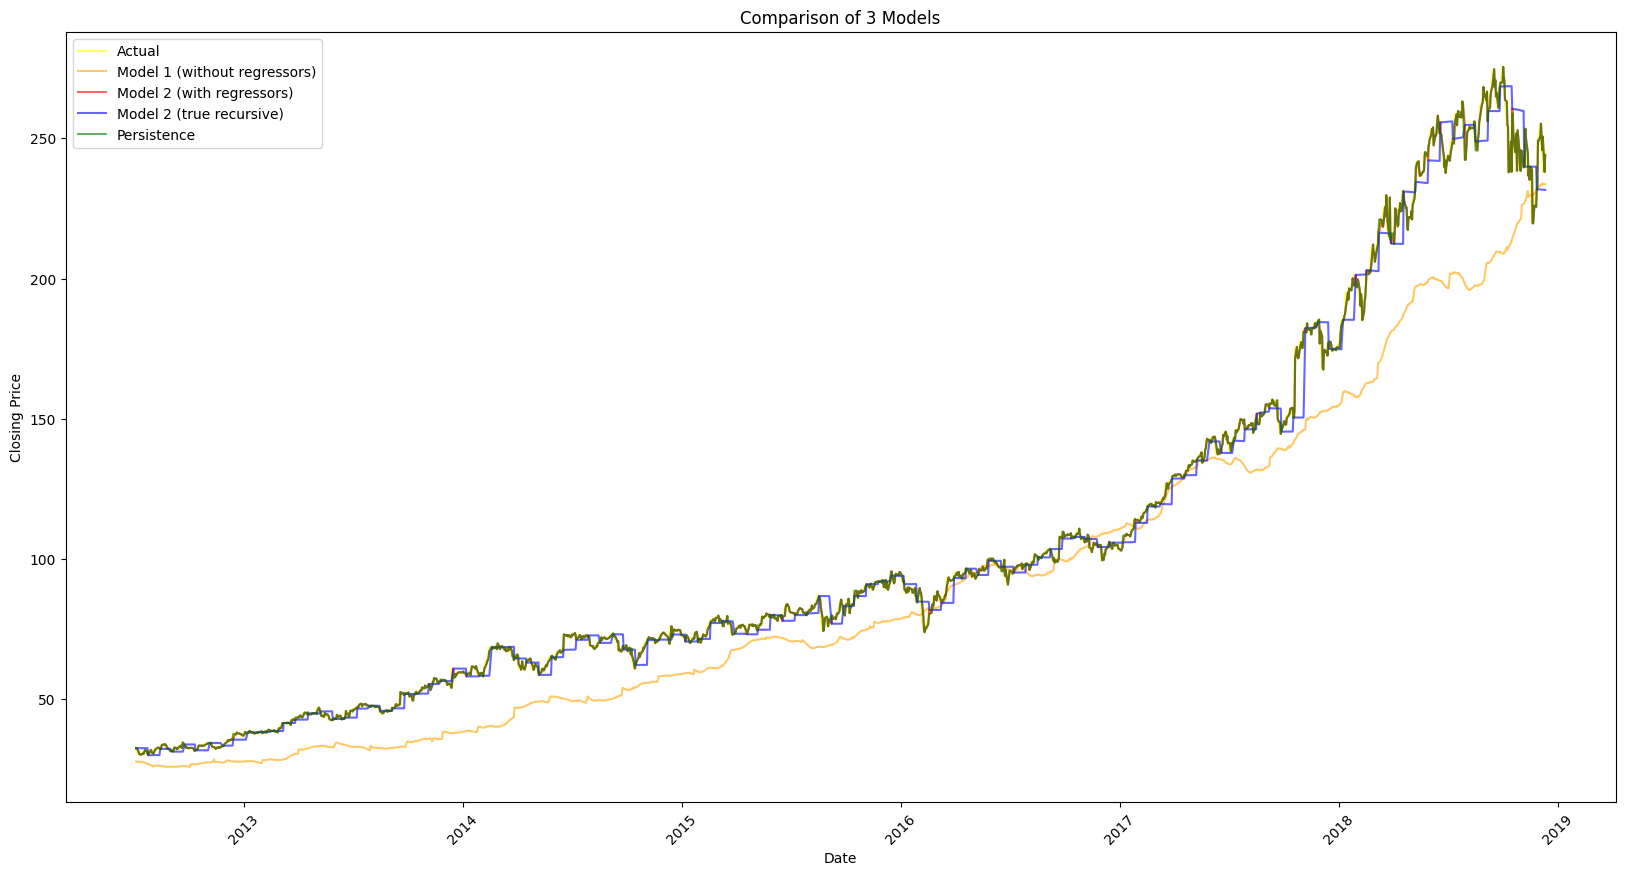

In [38]:
# visualize all 3 models' predictions side by side
plt.figure(figsize=(20, 10))
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(comparison_all_models_complete['ds'], comparison_all_models_complete['y_actual'], label='Actual', color = 'yellow', alpha = 0.6)
plt.plot(comparison_all_models_complete['ds'], comparison_all_models_complete['y_pred_no_reg'], label='Model 1 (without regressors)', color = 'orange', alpha=0.6)
plt.plot(comparison_all_models_complete['ds'], comparison_all_models_complete['y_pred_with_reg_nr'], label='Model 2 (with regressors)', color = 'red', alpha=0.6)
plt.plot(comparison_all_models_complete['ds'], comparison_all_models_complete['y_pred_with_reg'], label='Model 2 (true recursive)', color = 'blue', alpha=0.6)
plt.plot(comparison_all_models_complete['ds'], comparison_all_models_complete['y_pred_persistence'], label='Persistence', color = 'green', alpha=0.6)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Comparison of 3 Models')
plt.legend()
plt.show()

Now I'll create a test dataset ranging 2019 to test my model on. I'll first prepare my test dataset same as the train dataset.

In [47]:
# Filter a range for model training
start_date_test = '2019-01-01'
end_date_test = '2019-12-31'

# Filter ADBE stock with correct dates
adbe_test = adbe_df[(adbe_df['Date'] >= start_date_test) & (adbe_df['Date'] <= end_date_test)].copy()

adbe_test = adbe_test.set_index('Date')

In [48]:
test_df = adbe_test[['Adjusted Close']].reset_index()
test_df.rename(columns={'Date': 'ds', 'Adjusted Close': 'y'}, inplace=True)
test_df.head(n=20)

,ds,y
0,2019-01-02,224.570007
1,2019-01-03,215.699997
2,2019-01-04,226.190002
3,2019-01-07,229.259995
4,2019-01-08,232.679993
5,2019-01-09,235.429993
6,2019-01-10,237.770004
7,2019-01-11,237.550003
8,2019-01-14,234.559998
9,2019-01-15,242.360001


In [49]:
# log transformation
test_df_log = test_df.copy()
test_df_log['y'] = np.log1p(test_df_log['y'])
test_df_log.head(n=10)

,ds,y
0,2019-01-02,5.418631
1,2019-01-03,5.378514
2,2019-01-04,5.425787
3,2019-01-07,5.439209
4,2019-01-08,5.453953
5,2019-01-09,5.465652
6,2019-01-10,5.475501
7,2019-01-11,5.474579
8,2019-01-14,5.461966
9,2019-01-15,5.494542


Since Model 2 incorporates data leakage, and model 3, although true recursive in nature, results in poor r2 metrics, I'll test the test dataset with model 1.

In [57]:
# Test model_1 on test set (using existing trained model)
print(f"\nTesting Prophet on {len(test_df_log)} test data points")

# Make predictions on test set
forecast_test = model_1.predict(test_df_log)

# Reverse log transformation for actual scale metrics
test_results = pd.DataFrame({
    'ds': test_df_log['ds'],
    'y': test_df_log['y'],
    'yhat': forecast_test['yhat'],
    'yhat_lower': forecast_test['yhat_lower'],
    'yhat_upper': forecast_test['yhat_upper']
})

# Transform back to original scale
test_results['y_actual'] = np.expm1(test_results['y'])
test_results['yhat_actual'] = np.expm1(test_results['yhat'])
test_results['yhat_lower_actual'] = np.expm1(test_results['yhat_lower'])
test_results['yhat_upper_actual'] = np.expm1(test_results['yhat_upper'])

# Store predictions dataframe
predictions_test_no_regressors = test_results.copy()

# Calculate metrics in original scale
mae_test = mean_absolute_error(test_results['y_actual'], test_results['yhat_actual'])
rmse_test = np.sqrt(mean_squared_error(test_results['y_actual'], test_results['yhat_actual']))
mape_test = np.mean(np.abs((test_results['y_actual'] - test_results['yhat_actual']) /
                            (test_results['y_actual'] + 1e-8))) * 100
r2_test = r2_score(test_results['y_actual'], test_results['yhat_actual'])

# Coverage analysis
in_interval_test = np.sum((test_results['y_actual'] >= test_results['yhat_lower_actual']) &
                          (test_results['y_actual'] <= test_results['yhat_upper_actual']))
coverage_pct_test = (in_interval_test / len(test_results)) * 100
avg_width_pct_test = np.mean((test_results['yhat_upper_actual'] - test_results['yhat_lower_actual']) /
                              test_results['y_actual']) * 100

print("TEST SET RESULTS with Model 1")

print(f"\nPrediction Metrics:")
print(f"  MAE      = {mae_test:.3f}")
print(f"  RMSE     = {rmse_test:.3f}")
print(f"  MAPE     = {mape_test:.2f}%")
print(f"  R²       = {r2_test:.4f}")

print(f"\nUncertainty Interval Metrics:")
print(f"  Coverage = {coverage_pct_test:.1f}%")
print(f"  Avg Width = {avg_width_pct_test:.1f}%")


Testing Prophet on 252 test data points
TEST SET RESULTS with Model 1

Prediction Metrics:
  MAE      = 11.842
  RMSE     = 14.488
  MAPE     = 4.24%
  R²       = 0.5546

Uncertainty Interval Metrics:
  Coverage = 100.0%
  Avg Width = 77.3%


Here is the direct link to the dataset. The dataset is Adobe stock data from the datacard at this address https://www.kaggle.com/datasets/paultimothymooney/stock-market-data/data.